<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Copy_of_multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to illustrate the multivariate time series forecasting methods. Specifically, we will predict the energy demand and price for the next 24 hours in Spain using the following approaches:

CNN-LSTM-DNN

*   Single-Step Single-Output + Autoregressive
*   Single-Step Multi-Output + Autoregressive
*   Multi-Step Multi-Output (single shot)

XGBoost (single step multi-output)











##  1-Data Preprocessing


In [1]:
## Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import xgboost as xgb
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing
from joblib import Parallel, delayed
import time

In [2]:
random.seed(42)

In [3]:
# Load the dataset and show its info
df = pd.read_csv('energy_dataset.csv', usecols=['time','total load actual', 'price actual'])
print(f'The shape of the dataset is {df.shape}\n')
print(df.info())

The shape of the dataset is (35064, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
 2   price actual       35064 non-null  float64
dtypes: float64(2), object(1)
memory usage: 821.9+ KB
None


In [4]:
df.head()

,time,total load actual,price actual
0,2015-01-01 00:00:00+01:00,25385.0,65.41
1,2015-01-01 01:00:00+01:00,24382.0,64.92
2,2015-01-01 02:00:00+01:00,22734.0,64.48
3,2015-01-01 03:00:00+01:00,21286.0,59.32
4,2015-01-01 04:00:00+01:00,20264.0,56.04


In [5]:
## Parse time column and set index

# Convert to datetime
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Ensure time series is in ascending order
df.sort_index(inplace=True)

# Calculate time differences
time_diffs = df.index.to_series().diff()
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]             #Identify any irregularities, apart from the first row
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


In [6]:
# We are using data from the most recent three years (starting from January 1, 2016) for training, as it provides sufficient information while reducing computational time.
df = df[df.index >= '2016-01-01 00:00:00'].copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2016-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  26294 non-null  float64
 1   price actual       26303 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


In [8]:
## Handle Missing Values

non_numeric_values = ['?', 'N/A', '-', ''] # List of non-numeric values to replace

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')
# Check out null value situation
df.isna().sum()

,0
total load actual,9
price actual,0


In [9]:
df[df.isna().any(axis=1)]

,total load actual,price actual
time,,
2016-04-25 03:00:00,NaN,22.65
2016-04-25 05:00:00,NaN,40.18
2016-05-10 21:00:00,NaN,39.11
2016-07-09 20:00:00,NaN,51.72
2016-09-28 07:00:00,NaN,56.40
2017-11-14 11:00:00,NaN,66.17
2017-11-14 18:00:00,NaN,75.45
2018-06-11 16:00:00,NaN,64.93
2018-07-11 07:00:00,NaN,69.79


In [10]:
# Impute the missing values using linear interpolation
df['total load actual'] = df['total load actual'].interpolate(method='linear')

# Check
df.isna().sum()

,0
total load actual,0
price actual,0


In [11]:
## Check data type again
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2016-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  26303 non-null  float64
 1   price actual       26303 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


All date types are good, no conversion is needed.

## 2-EDA

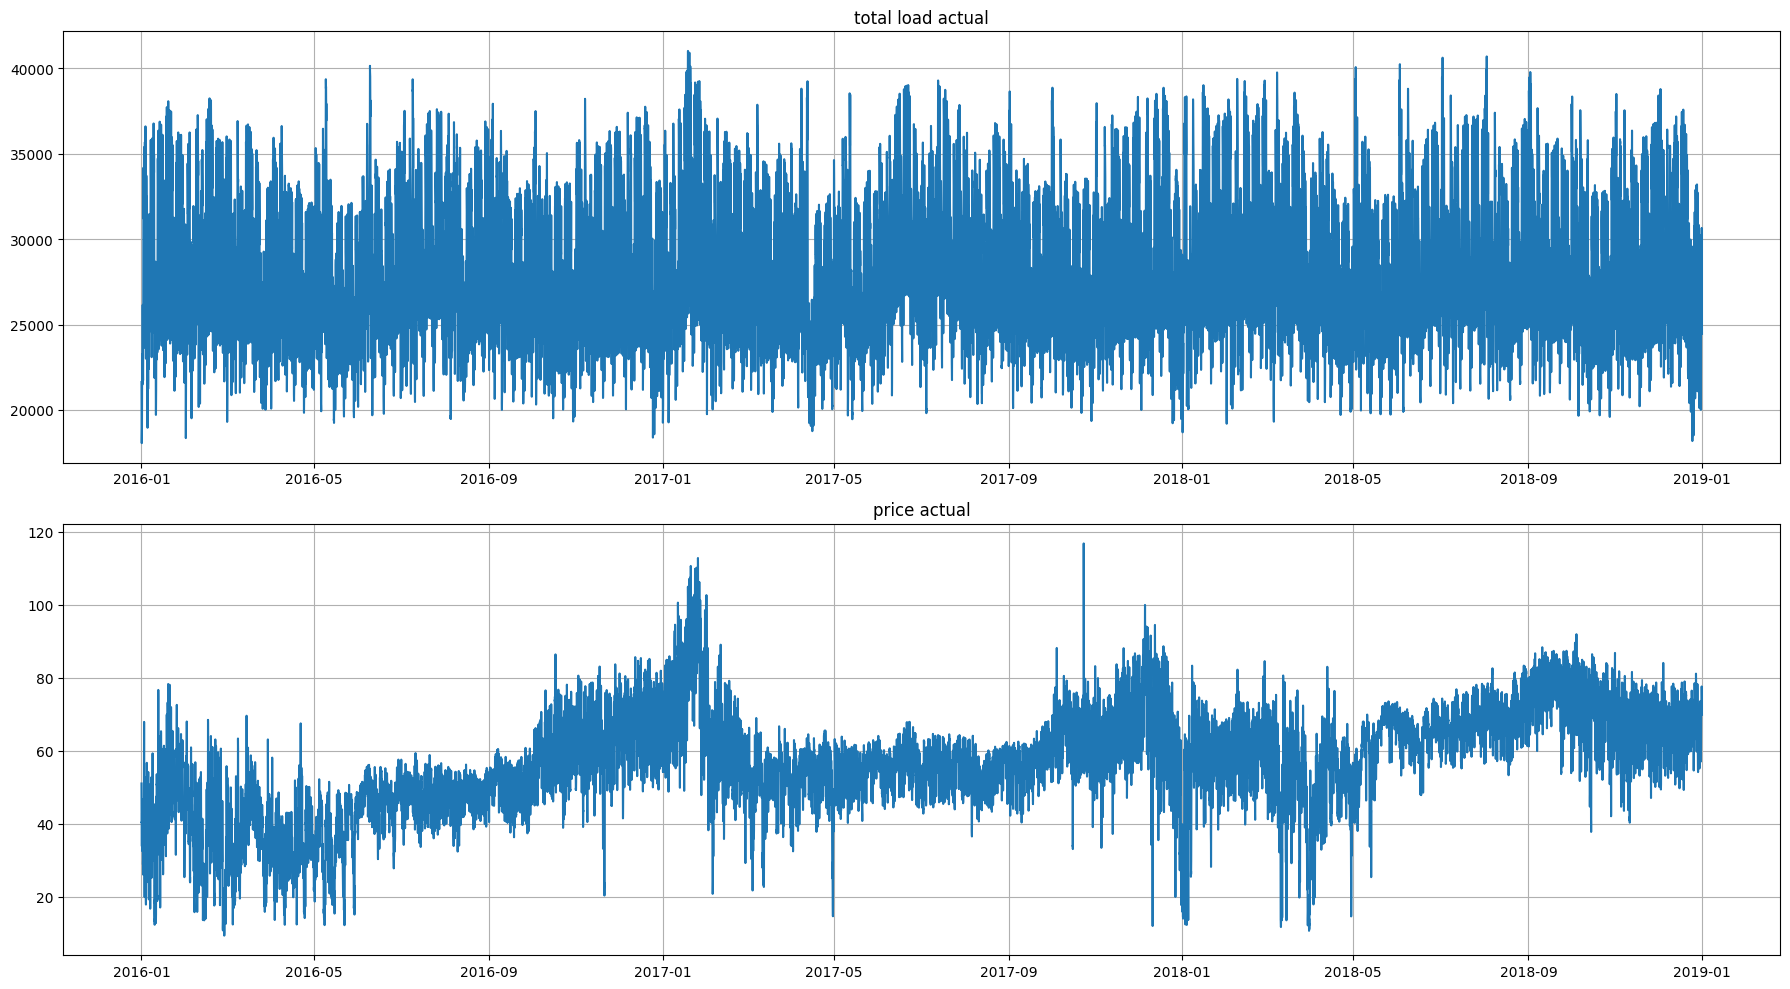

In [12]:
##Visualizing Data

fig, axs = plt.subplots(len(df.columns), 1, figsize=(18, 10)) # Changed the first argument to len(df.columns)

for i, col in enumerate(df.columns):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

The plot suggests that load exhibits greater stability compared to price

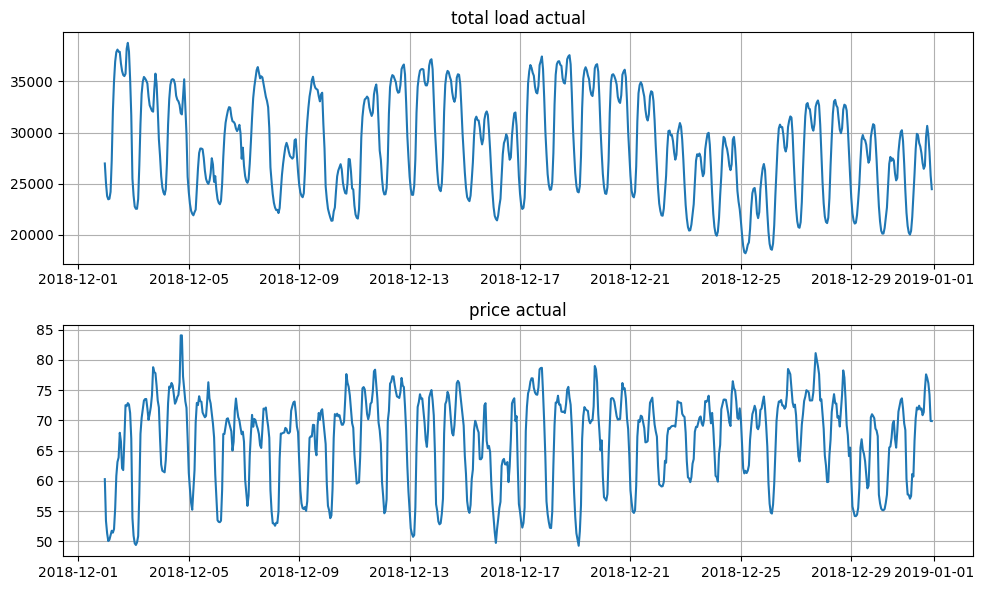

In [13]:
# Visualize the last few daya
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 6))

for i, col in enumerate(df.columns):
    axs[i].plot(df[col][-24*30:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

There are clear seasonal patterns in both curves, and adding time features will likely help models capture these trends.

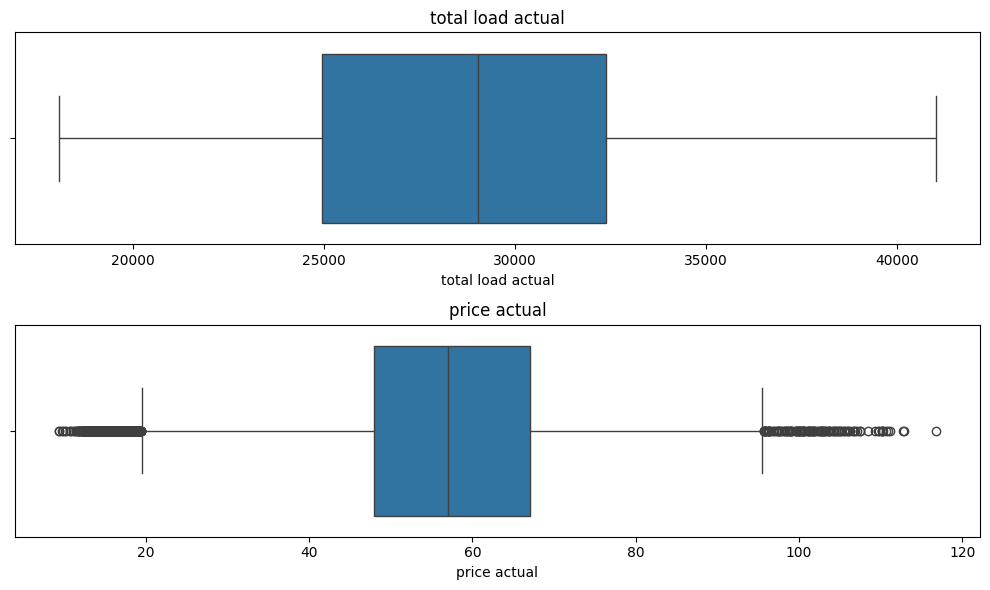

In [14]:
# Check outliers
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10,6))

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

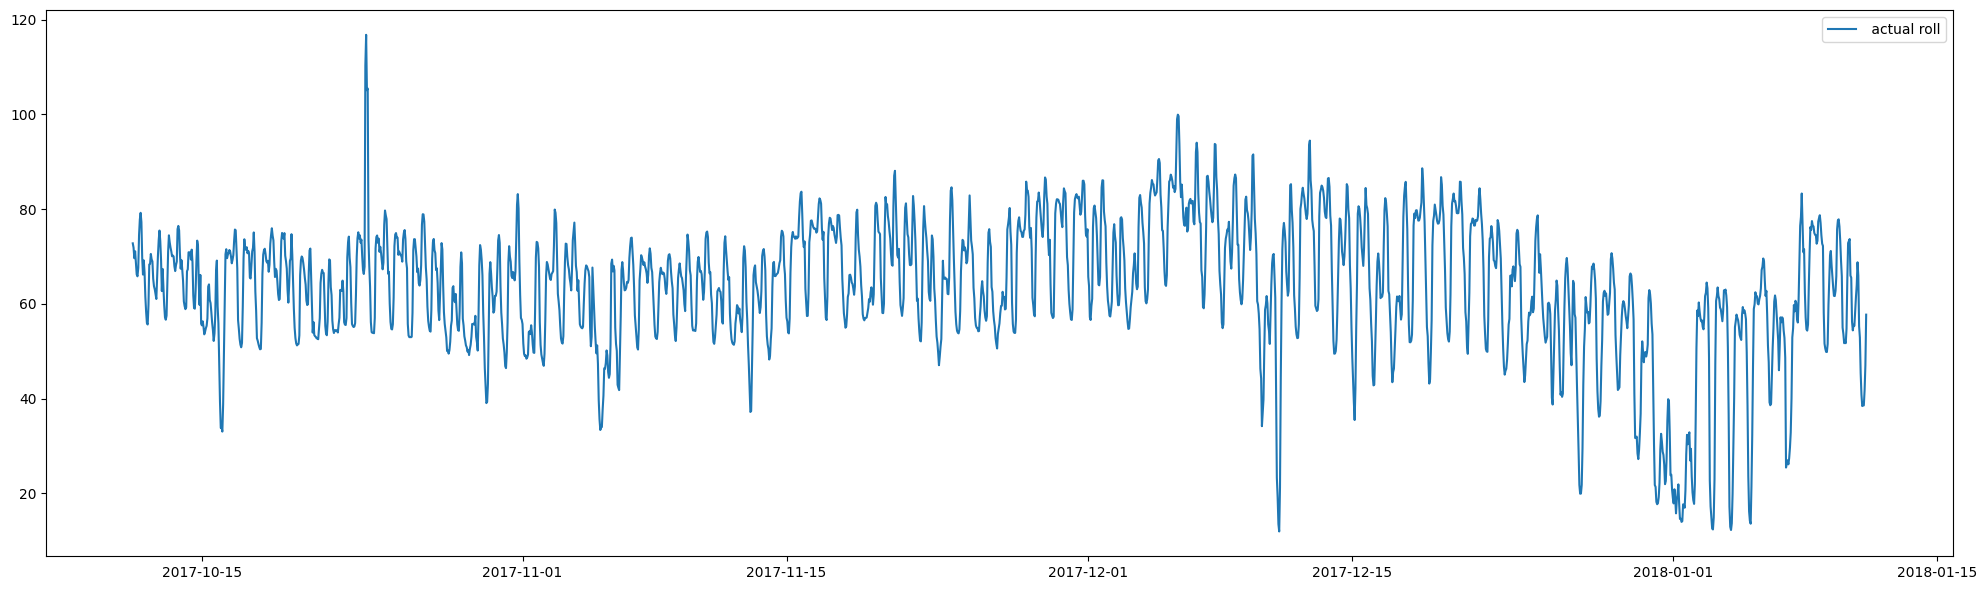

In [15]:
# Visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

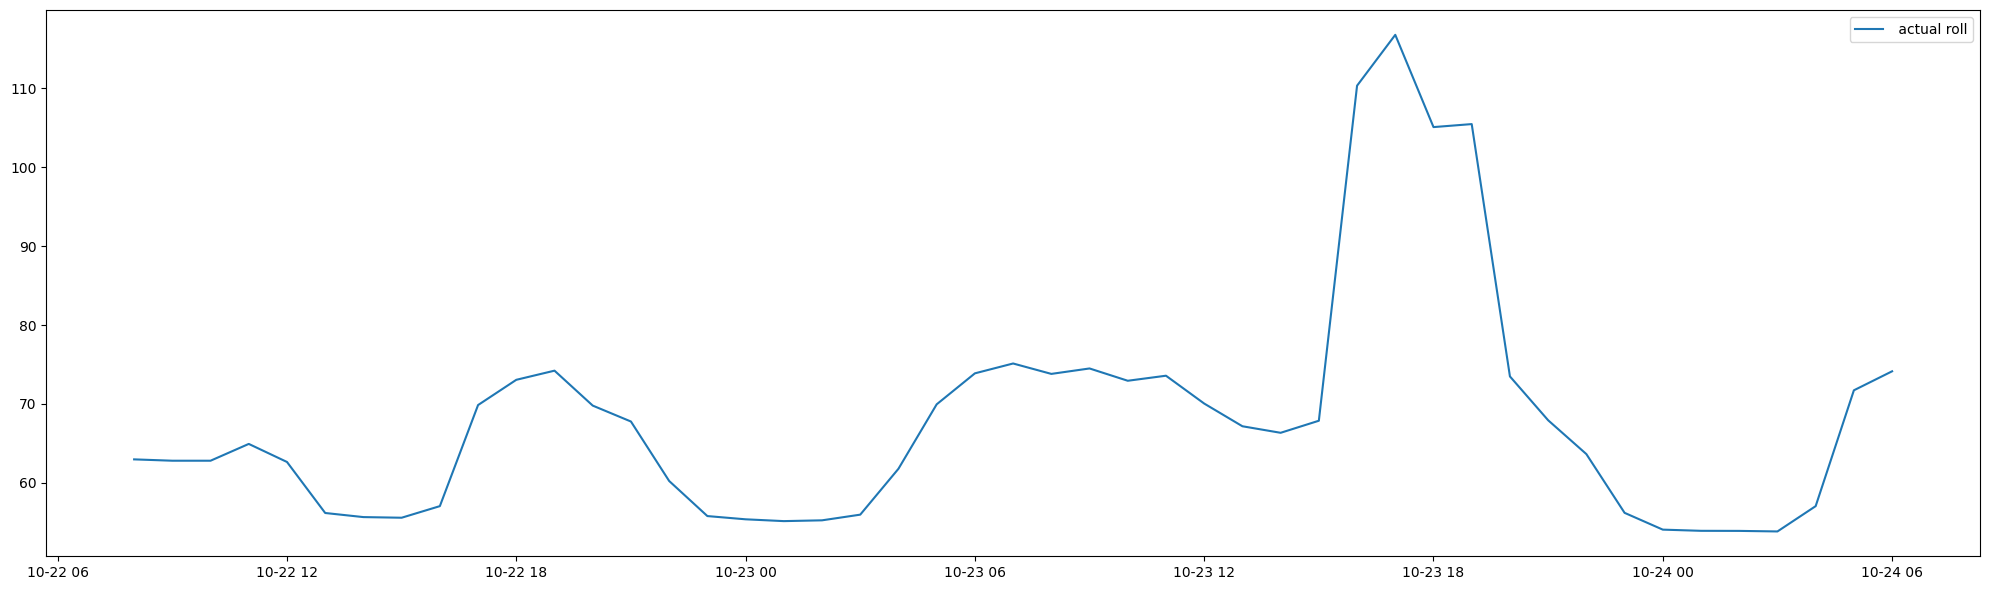

In [16]:
# Zoom in and sisualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-22 07:00:00') & (df.index < '2017-10-24 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual,26303.0,28810.257138,4545.474497,18054.00,24932.50,29016.0,32371.00,41015.0
price actual,26303.0,56.726108,14.592461,9.33,47.99,57.0,67.02,116.8


The features are on different scales, so we need to apply scaling.

## 3-Feature Engineering

In [18]:
# Add some extra features

def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = add_time_features(df)

In [19]:
# Correlation
df.corr() # The results show that 'hour' and 'dayofweek' are indeed higyly related to our desired targets.

,total load actual,price actual,hour,dayofweek
total load actual,1.000000,0.409105,0.394732,-0.196502
price actual,0.409105,1.000000,0.212474,-0.157526
hour,0.394732,0.212474,1.000000,0.000095
dayofweek,-0.196502,-0.157526,0.000095,1.000000


In [20]:
## Smooth features

original_cols = ['total load actual', 'price actual']
rolling_size = 8
for col in original_cols:
    df[f'{col} rolling'] = df[col].rolling(window=rolling_size).mean()
df.dropna(inplace=True)

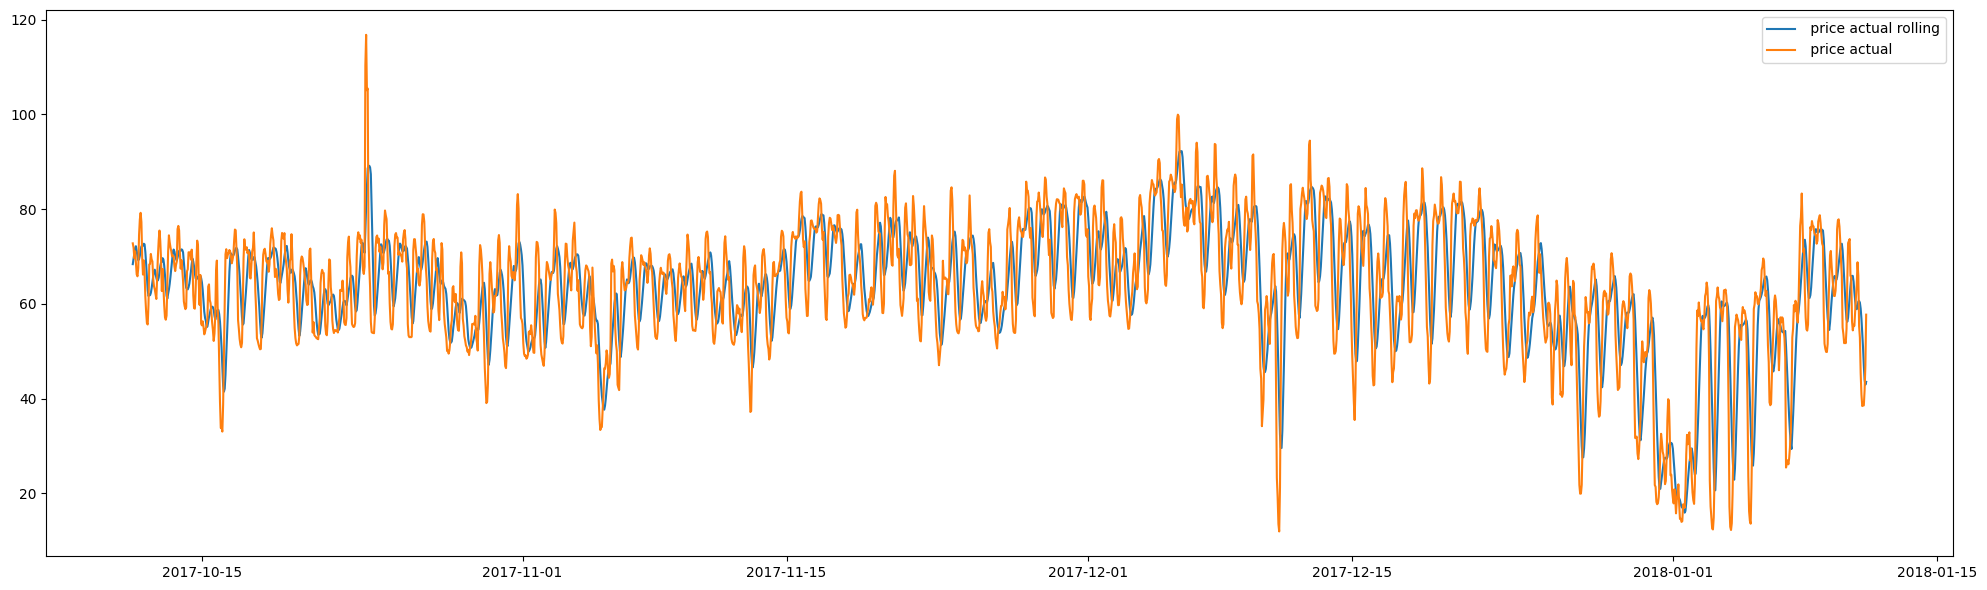

In [21]:
# Visualize part of the data again
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual rolling'], label=' price actual rolling')
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' price actual')

plt.legend()
plt.tight_layout()
plt.show()

In [22]:
## Train Test Split

split_step = int(df.shape[0]*0.8)
train = df.iloc[:split_step].copy()
ver = df.iloc[split_step:].copy()
valid = ver.iloc[:int(ver.shape[0]*0.5)].copy()
test = ver.iloc[int(ver.shape[0]*0.5):].copy()

# For XGBoost
train_xgb, valid_xgb, test_xgb = train.copy(), valid.copy(), test.copy()

# For CNN-LSTM-DNN

## Scaling Function
# Initialize the scalers
rolling_scaler = MinMaxScaler()
load_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()



rolling_columns = ['total load actual rolling', 'price actual rolling',]
for col in rolling_columns:
    train.loc[:,f'{col} scaled'] = rolling_scaler.fit_transform(train[[col]])
    valid.loc[:,f'{col} scaled'] = rolling_scaler.transform(valid[[col]])
    test.loc[:,f'{col} scaled'] = rolling_scaler.transform(test[[col]])

train.loc[:,'total load actual scaled'] = load_scaler.fit_transform(train[['total load actual']])
train.loc[:,'price actual scaled'] = price_scaler.fit_transform(train[['price actual']])

valid.loc[:,'total load actual scaled'] = load_scaler.transform(valid[['total load actual']])
valid.loc[:,'price actual scaled'] = price_scaler.transform(valid[['price actual']])
test.loc[:,'total load actual scaled'] = load_scaler.transform(test[['total load actual']])
test.loc[:,'price actual scaled'] = price_scaler.transform(test[['price actual']])

# Drop rolling columns
train.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
valid.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
test.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)

# Final, we get the datasets ready for michine learning
train_s = train.drop(['total load actual', 'price actual'], axis=1)
valid_s = valid.drop(['total load actual', 'price actual'], axis=1)
test_s = test.drop(['total load actual', 'price actual'], axis=1)


In [23]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  int32  
 1   dayofweek                         21036 non-null  int32  
 2   total load actual rolling scaled  21036 non-null  float64
 3   price actual rolling scaled       21036 non-null  float64
 4   total load actual scaled          21036 non-null  float64
 5   price actual scaled               21036 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 986.1 KB


In [24]:
# To save memory, it is sufficient to use float32
train_s = train_s.astype(np.float32)
valid_s = valid_s.astype(np.float32)
test_s = test_s.astype(np.float32)

In [25]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  float32
 1   dayofweek                         21036 non-null  float32
 2   total load actual rolling scaled  21036 non-null  float32
 3   price actual rolling scaled       21036 non-null  float32
 4   total load actual scaled          21036 non-null  float32
 5   price actual scaled               21036 non-null  float32
dtypes: float32(6)
memory usage: 657.4 KB


## 4-Model Building

### 4.1 Single Step + Autoregressive

#### 4-1-1, Ss Single-Output (CNN_LSTM_DNN)


In [27]:
def single_step_windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, input_columns, output_columns, column_names):
    """Generates dataset windows for single-step forecasting

    Args:
      series (array of float) - The time series data (can be multivariate).
      window_size (int) - Number of time steps in each input window.
      batch_size (int) - Number of samples per batch.
      shuffle_buffer_size (int) - Buffer size for shuffling the dataset.
      input_columns (list of str, or ints) - Column names or indices to be used as features.
      output_columns (str, or ints) - Column names or indices to be used as labels (target variables).
      column_names (list of str, optional) - List of column names in the input dataset.

    Returns:
      dataset (TF Dataset) - A TensorFlow dataset containing feature and label pairs.
    """

    # Specify the postions of input and output features
    if column_names is not None:
        input_columns = [column_names.index(col) if isinstance(col, str) else col for col in input_columns]
        output_columns = [column_names.index(col) if isinstance(col, str) else col for col in output_columns]
    else:
        raise ValueError(f"column_names are missing")


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data, ensuring each window has the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # +1 refers to forecasting 1 time step

    # Flatten the windows into individual sequences
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Map each window to a tuple of (features, labels), where the label is the next time step
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], input_columns, axis=-1),
                                          tf.gather(window[-1], output_columns, axis=-1))) # Here, -1 refers to single step method, we only forecast the next 1 time step

    # Shuffle the dataset
    dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches and prefetch to optimize performance
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

def model_forecast(model, test_series, window_size, batch_size):
    """Generates predictions on test data windows using the provided model

    Args:
      model (TF Keras Model) - Trained model that accepts data windows.
      test_series (array of float) - The time series data to make predictions on.
      window_size (int) - Number of time steps in each input window.
      batch_size (int) - Number of samples per batch.

    Returns:
      forecast (numpy array) - Array of predictions made by the model.
    """

    # Create a TensorFlow dataset from the test time series
    dataset = tf.data.Dataset.from_tensor_slices(test_series)

    # Window the test data into sequences of the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows into individual sequences
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches and prefetch to optimize performance
    dataset = dataset.batch(batch_size).prefetch(1)

    # Use the model to predict the next time step for each window
    forecast = model.predict(dataset)

    return forecast

In [28]:
# Initialize Parameters
column_names = train_s.columns.to_list()
input_cols = train_s.columns.to_list()
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

Load Model

In [29]:
# Load
output_cols = ['total load actual scaled']

def create_uncompiled_load_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def create_load_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=435,
        decay_rate=0.95,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_load_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model


# datasets preparation
train_load_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_load_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)




In [ ]:
# Initilize Model
single_step_single_output_load_model = create_load_model(initial_lr=1e-1)

# Fitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)
history = single_step_single_output_load_model.fit(train_load_set, validation_data=validation_load_set, epochs=40, callbacks=[early_stopping])

77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
ss_load mse: 561750.9491855024
ss_load mae: 583.4251259773558


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


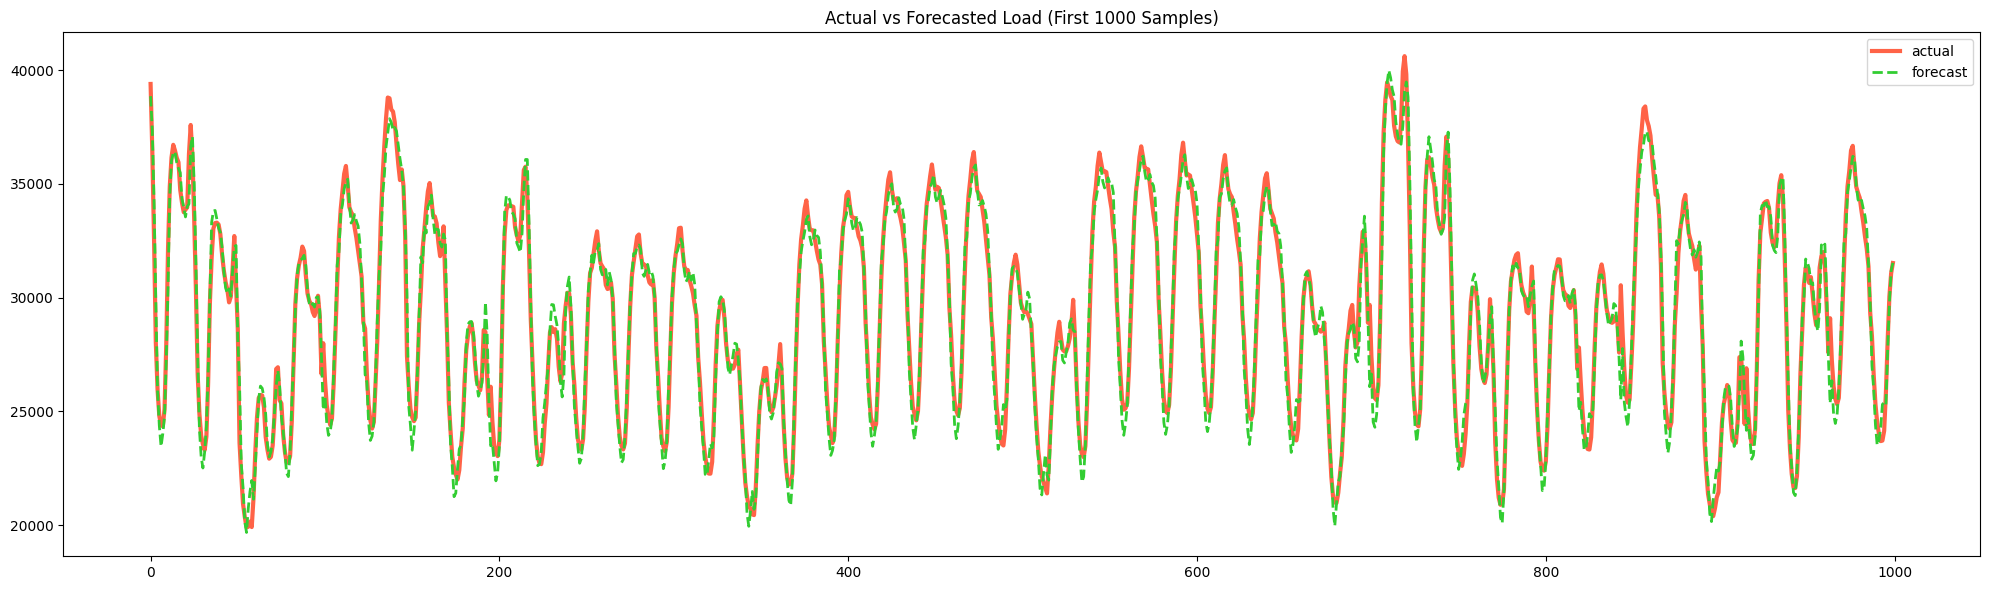

In [87]:
single_step_single_output_load_model = load_model('single step single output load model.h5')

# Forecasting
load_prediction_scaled = model_forecast(single_step_single_output_load_model, valid_s, window_size, batch_size)
load_actual_scaled = valid_s.iloc[window_size:]['total load actual scaled'].values

ss_load_scaled_mse = mean_squared_error(load_actual_scaled, load_prediction_scaled[:-1])
ss_load_scaled_mae = mean_absolute_error(load_actual_scaled, load_prediction_scaled[:-1])

# Use the load_scaler to inverse transform the predicted values
load_prediction_original = load_scaler.inverse_transform(load_prediction_scaled)
load_actual_original =  valid.iloc[window_size:]['total load actual'].values

ss_load_mse = mean_squared_error(load_actual_original, load_prediction_original[:-1])
ss_load_mae = mean_absolute_error(load_actual_original, load_prediction_original[:-1])

print(f'ss_load mse: {ss_load_mse}')
print(f'ss_load mae: {ss_load_mae}')

#Visualize the performance
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(load_actual_original[:1000], c='Tomato', label='actual', linestyle='-', linewidth=3)
ax.plot(load_prediction_original[:1000], c= 'LimeGreen', label='forecast', linestyle='--',linewidth=2)
ax.set_title('Actual vs Forecasted Load (First 1000 Samples)')

plt.legend()
plt.tight_layout()
plt.show()

Price Model

In [34]:
output_cols = ['price actual scaled']
def create_uncompiled_price_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        #tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def create_price_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=400,
        decay_rate=0.8,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_price_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

train_price_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_price_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)



In [ ]:
single_step_single_output_price_model = create_price_model(initial_lr=1e-1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)

history = single_step_single_output_price_model.fit(train_price_set, validation_data=validation_price_set, epochs=20, callbacks=[early_stopping])

Epoch 1/20
    655/Unknown 25s 33ms/step - loss: 0.0086 - mae: 0.0931

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


656/656 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 0.0086 - mae: 0.0931 - val_loss: 0.0044 - val_mae: 0.0823
Epoch 2/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 0.0036 - mae: 0.0656 - val_loss: 7.0892e-04 - val_mae: 0.0297
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 0.0018 - mae: 0.0467 - val_loss: 0.0013 - val_mae: 0.0432
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.0011 - mae: 0.0368 - val_loss: 5.4386e-04 - val_mae: 0.0263
Epoch 5/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 9.9596e-04 - mae: 0.0341 - val_loss: 5.0255e-04 - val_mae: 0.0253
Epoch 6/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - loss: 8.6962e-04 - mae: 0.0319 - val_loss: 5.8264e-04 - val_mae: 0.0272
Epoch 7/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - loss: 8.2151e-04 - mae: 0.0310 - val_loss: 0.0010 - val_mae: 0.0361
Epoch 8/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7.7186e-04 - mae: 0.0298 - val_loss: 5.5877e-04 - val_mae: 0.0266
Epoch 9/20
656/

77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ss_price mse: 10.355359700748807
ss_price mae: 2.600157564412666


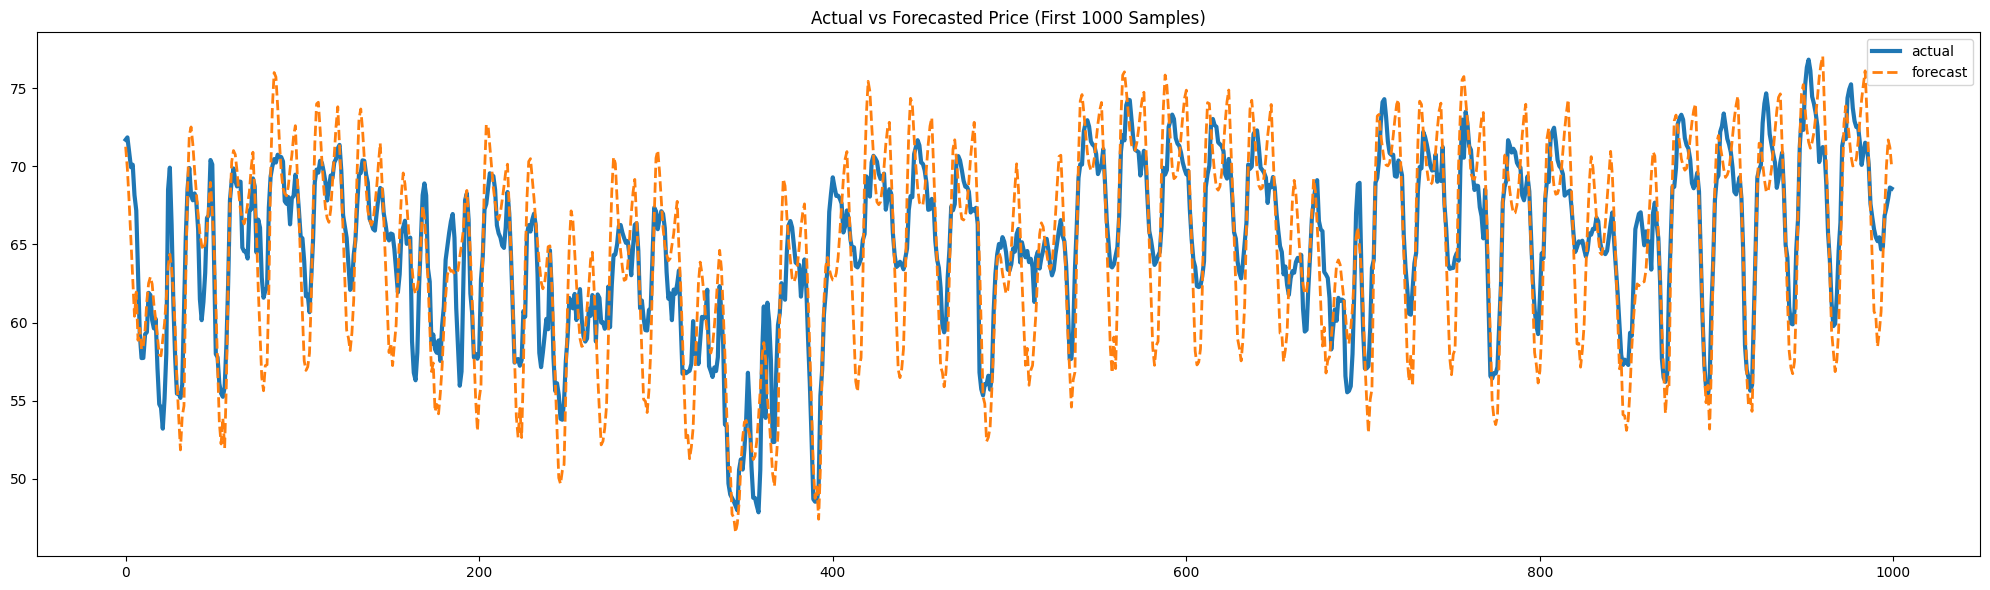

In [88]:
# Load the pretrained model
single_step_single_output_price_model = load_model('single step single output price model.h5')

# Forecast
price_prediction_scaled = model_forecast(single_step_single_output_price_model, valid_s, window_size, batch_size)

# Actual values
price_actual_scaled = valid_s.iloc[window_size:]['price actual scaled'].values

# Use the price_scaler to inverse transform the predicted values
price_prediction_original = price_scaler.inverse_transform(price_prediction_scaled)
price_actual_original =  valid.iloc[window_size:]['price actual'].values

# Evaluate

ss_price_scaled_mse = mean_squared_error(price_actual_scaled, price_prediction_scaled[:-1])
ss_price_scaled_mae = mean_absolute_error(price_actual_scaled, price_prediction_scaled[:-1])

ss_price_mse = mean_squared_error(price_actual_original, price_prediction_original[:-1])
ss_price_mae = mean_absolute_error(price_actual_original, price_prediction_original[:-1])

print(f'ss_price mse: {ss_price_mse}')
print(f'ss_price mae: {ss_price_mae}')

#Visualize the performance
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual_original[:1000], c='#1f77b4', label='actual', linestyle='-', linewidth=3)
ax.plot(price_prediction_original[:1000], c= '#ff7f0e', label='forecast', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Price (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

#single_step_single_output_price_model.save('single step single output price model.h5')

Autoregressive forecasting

In [36]:
# If we want to further forecast next multi-steps, we can use the following autoregressive forecasting algorithm

multiprocessing.set_start_method('forkserver', force=True)

def forecast_single_window(last_step, test_data, model_load, model_price, forecast_size, window_size, rolling_size):
    """
    Forecasts load and price for a single window using rolling predictions.

    Parameters:
    - last_step: The end index of the current window.
    - test_data: Historical data for forecasting.
    - model_load: Model for load prediction.
    - model_price: Model for price prediction.
    - forecast_size: Number of future steps to predict.
    - window_size: Size of the input window.
    - rolling_size: Size of the buffer for rolling averages.

    Returns:
    - forecast_steps: List of (load, price) predictions for each step.
    """

    # Extract the last window of data for this forecast
    last_rows = test_data[last_step - window_size:last_step]
    input_data = last_rows.values.reshape(1, window_size, last_rows.shape[1])

    # Initialize rolling buffers as NumPy arrays
    roll_load_buffer = np.array(last_rows['total load actual scaled'].values[-rolling_size :])  # Using column index 2
    roll_price_buffer = np.array(last_rows['price actual scaled'].values[-rolling_size:])  # Using column index 3

    # Initialize the current time based on the last row of last_rows
    current_time = last_rows.index[-1]  # Assuming the index of test_data contains the timestamp

    forecast_steps = []

    for _ in range(forecast_size):
        # Predict the next load and price
        next_load = model_load.predict(input_data)
        next_price = model_price.predict(input_data)

        # Collect predictions
        forecast_steps.append((next_load[0][0], next_price[0][0]))

        # Updata buffers
        roll_load_buffer[:-1] = roll_load_buffer[1:]
        roll_load_buffer[-1] = next_load[0][0]

        roll_price_buffer[:-1] = roll_price_buffer[1:]
        roll_price_buffer[-1] = next_price[0][0]

        # Calculate new rolling scaled values
        total_load_roll_scaled = np.mean(roll_load_buffer)
        price_roll_scaled = np.mean(roll_price_buffer)

        # Update time for next prediction
        current_time += pd.Timedelta(hours=1)  # Increment the current time by 1 hour
        new_hour = current_time.hour
        new_dayofweek = current_time.dayofweek

        # Prepare next input
        next_input = np.array([[new_hour, new_dayofweek, total_load_roll_scaled, price_roll_scaled,
                                next_load[0][0], next_price[0][0]]])
        input_data = np.append(input_data[:, 1:, :], [next_input], axis=1)

    return forecast_steps

def rolling_window_forecast(test_data, model_load, model_price, forecast_size, window_size, rolling_size):
    """
    Performs rolling window forecasts in parallel using the specified models for load and price.

    Parameters:
    - test_data: The dataset containing historical data for forecasting.
    - model_load: The trained model for load forecasting.
    - model_price: The trained model for price forecasting.
    - forecast_size: The number of time steps to forecast for each window.
    - window_size: The size of the input window used for each forecast.
    - rolling_size: The size of the rolling buffer used for rolling forecasts.

    Returns:
    - predictions: A NumPy array containing the forecasted load and price for each window.
    """

    predictions = Parallel(n_jobs=-1)(
        delayed(forecast_single_window)(last_step,
                                        test_data,
                                        single_step_single_output_load_model,
                                        single_step_single_output_price_model, forecast_size,
                                        window_size, rolling_size)
        for last_step in range(window_size, len(test_data) - forecast_size+1))

    predictions = np.array(predictions)

    return predictions

# Example usage:
forecast_size = 24  # Forecasting the next 24 hours
window_size = 48  # Using the last 48 hours for the input window
rolling_size = 3  # Keeping a rolling buffer of the last 3 values
test_data = test_s[:window_size+forecast_size+24]  # Adjusting test data size

# Rolling forecast
predictions = rolling_window_forecast(test_data, single_step_single_output_load_model, single_step_single_output_price_model, forecast_size, window_size, rolling_size)

# Get rolling actual window data
def create_rolling_window(dataset, window_size=24):
    """
    Converts a 1D dataset into a 2D dataset with a rolling window.

    Parameters:
    dataset (pd.Series or np.array): The input 1D array or series.
    window_size (int): The size of the rolling window (number of steps).

    Returns:
    np.array: A 2D array where each row contains the next 'window_size' values.
    """
    # Create the rolling window view of the data using numpy's stride tricks
    rolling_window = np.lib.stride_tricks.sliding_window_view(dataset, window_size)

    return rolling_window

actual_load_rolled = create_rolling_window(test_data['total load actual scaled'].values[window_size:], window_size=forecast_size)
actual_price_rolled = create_rolling_window(test_data['price actual scaled'].values[window_size:], window_size=forecast_size)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [37]:
# Extract predicted values
predicted_load = predictions[:, :, 0]  # Load is at index 0
predicted_price = predictions[:, :, 1]  # Price is at index 1

# Evaluate on scaled values
mse_load = mean_squared_error(actual_load_rolled, predicted_load)
mae_load = mean_absolute_error(actual_load_rolled, predicted_load)

mse_price = mean_squared_error(actual_price_rolled, predicted_price)
mae_price = mean_absolute_error(actual_price_rolled, predicted_price)

print(f"Load - MSE: {mse_load}, MAE: {mae_load}")
print(f"Price - MSE: {mse_price}, MAE: {mae_price}")

# Optionally, we could further evaluate the model performance on the original (unscaled) values,
# but we are omitting the details of inverse scaling here for simplicity.


Load - MSE: 0.02796693705022335, MAE: 0.13460682332515717
Price - MSE: 0.017385827377438545, MAE: 0.11444834619760513


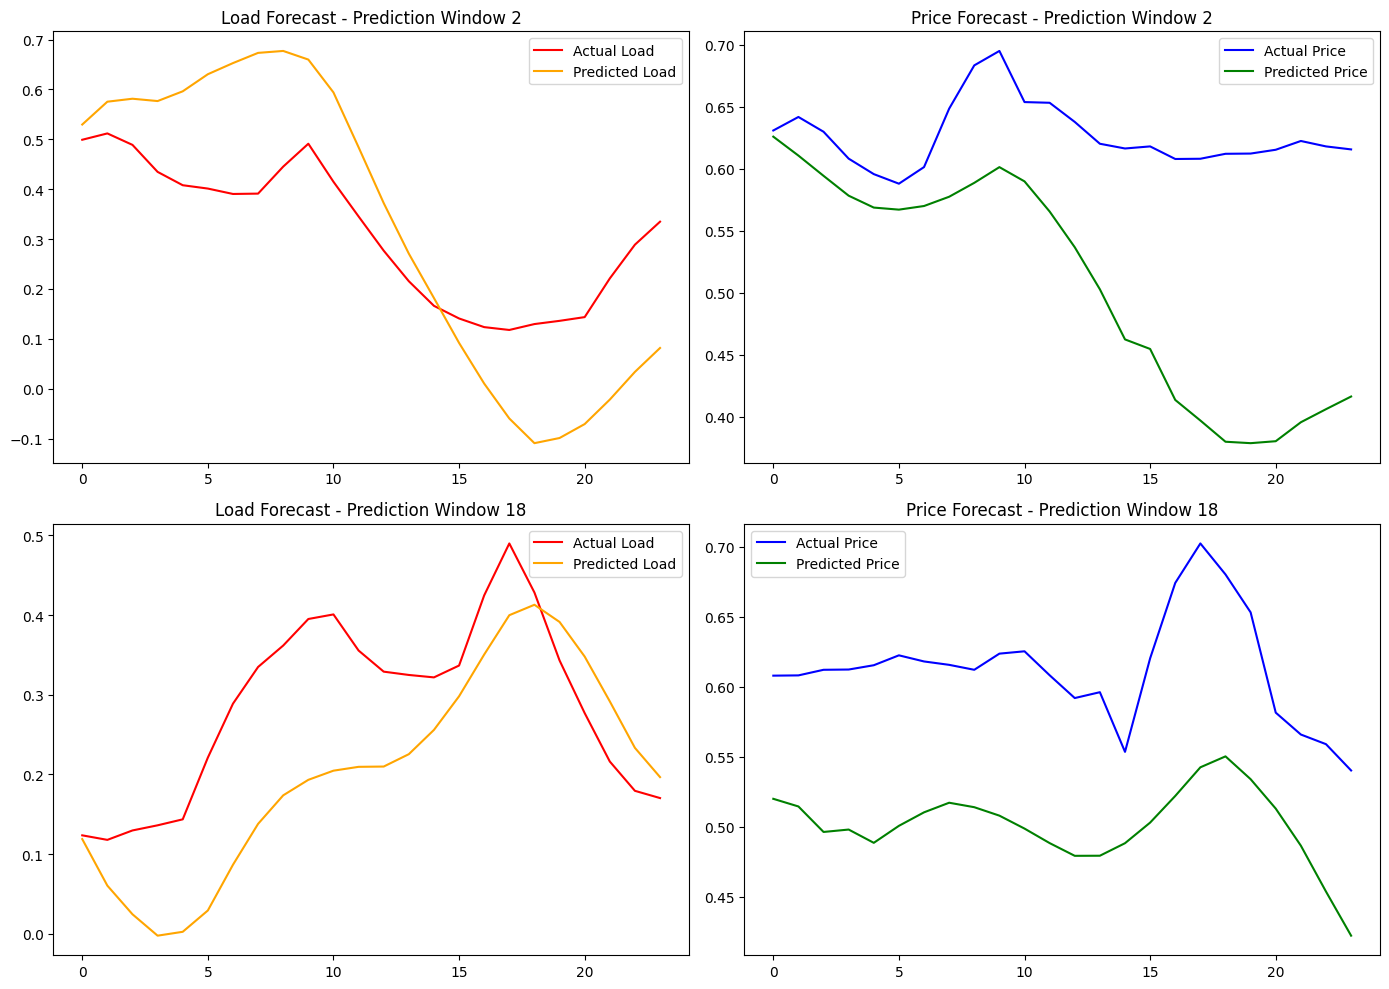

In [38]:
# Randomly choose two different prediction windows
random_windows = np.random.choice(predictions.shape[0], size=2, replace=False)
# Plot predictions vs actual values for the randomly selected windows
plt.figure(figsize=(14, 10))

for i, window in enumerate(random_windows):
    plt.subplot(2, 2, i * 2 + 1)
    plt.plot(actual_load_rolled[window], label='Actual Load', color='red')
    plt.plot(predicted_load[window], label='Predicted Load', color='orange')
    plt.title(f'Load Forecast - Prediction Window {window + 1}')
    plt.legend()

    plt.subplot(2, 2, i * 2 + 2)
    plt.plot(actual_price_rolled[window], label='Actual Price', color='blue')
    plt.plot(predicted_price[window], label='Predicted Price', color='green')
    plt.title(f'Price Forecast - Prediction Window {window + 1}')
    plt.legend()

plt.tight_layout()
plt.show()


#### 4-1-2, Ss Multi-Output (CNN_LSTM_DNN)

In [39]:
output_cols = ['total load actual scaled', 'price actual scaled'] # predict multiple labels simultaneously

input_cols = column_names
column_names = train_s.columns.to_list()
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

train_set = single_step_windowed_dataset(
      series=train_s,
      window_size=window_size,
      batch_size=batch_size,
      shuffle_buffer_size=shuffle_buffer_size,
      input_columns=input_cols,
      output_columns=output_cols,
      column_names=column_names)

validation_set = single_step_windowed_dataset(
      series=valid_s,
      window_size=window_size,
      batch_size=batch_size,
      shuffle_buffer_size=shuffle_buffer_size,
      input_columns=input_cols,
      output_columns=output_cols,
      column_names=column_names)

# Build CNN-LSTM-DNN Model
def create_uncompiled_sm_model():
# Build CNN-LSTM-DNN Model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(2),
    ])
    return model

def create_sm_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=656,
        decay_rate=0.95,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_sm_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

In [ ]:
single_step_multi_output_model = create_sm_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)

history = single_step_multi_output_model.fit(train_set, validation_data=validation_set, epochs=40, callbacks=[early_stopping])

Epoch 1/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 91s 77ms/step - loss: 0.0105 - mae: 0.1078 - val_loss: 0.0070 - val_mae: 0.0974
Epoch 2/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 74ms/step - loss: 0.0056 - mae: 0.0819 - val_loss: 0.0035 - val_mae: 0.0664
Epoch 3/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 84s 77ms/step - loss: 0.0040 - mae: 0.0693 - val_loss: 0.0030 - val_mae: 0.0613
Epoch 4/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 49s 74ms/step - loss: 0.0030 - mae: 0.0599 - val_loss: 0.0025 - val_mae: 0.0541
Epoch 5/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 85s 78ms/step - loss: 0.0023 - mae: 0.0521 - val_loss: 0.0025 - val_mae: 0.0531
Epoch 6/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - loss: 0.0021 - mae: 0.0493 - val_loss: 0.0020 - val_mae: 0.0488
Epoch 7/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - loss: 0.0019 - mae: 0.0469 - val_loss: 0.0020 - val_mae: 0.0474
Epoch 8/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - loss: 0.0017 - mae: 0.0451 - val_loss: 0.0015 - val_mae: 0.0418
Epoch 9/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 

77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


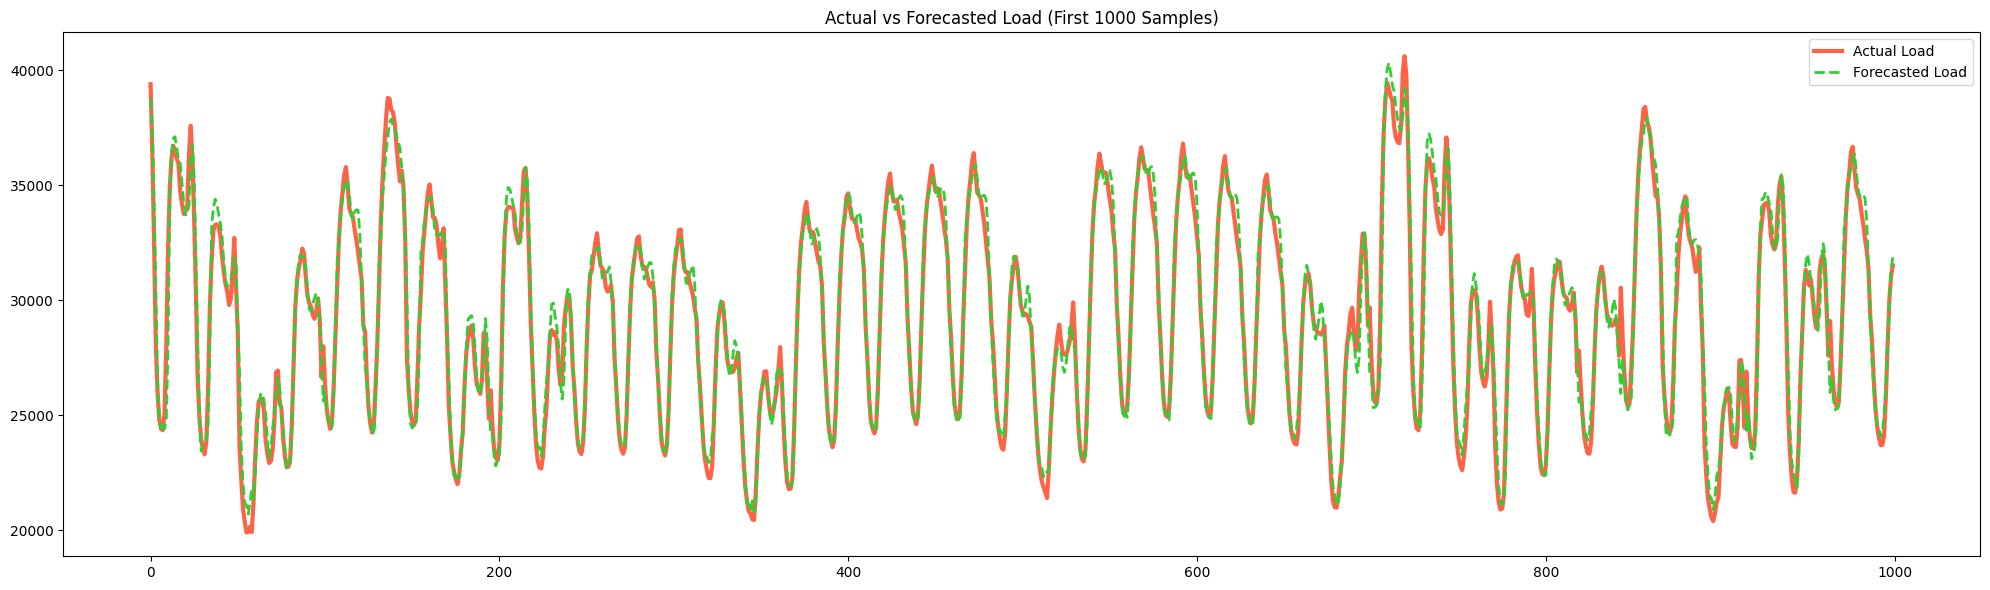

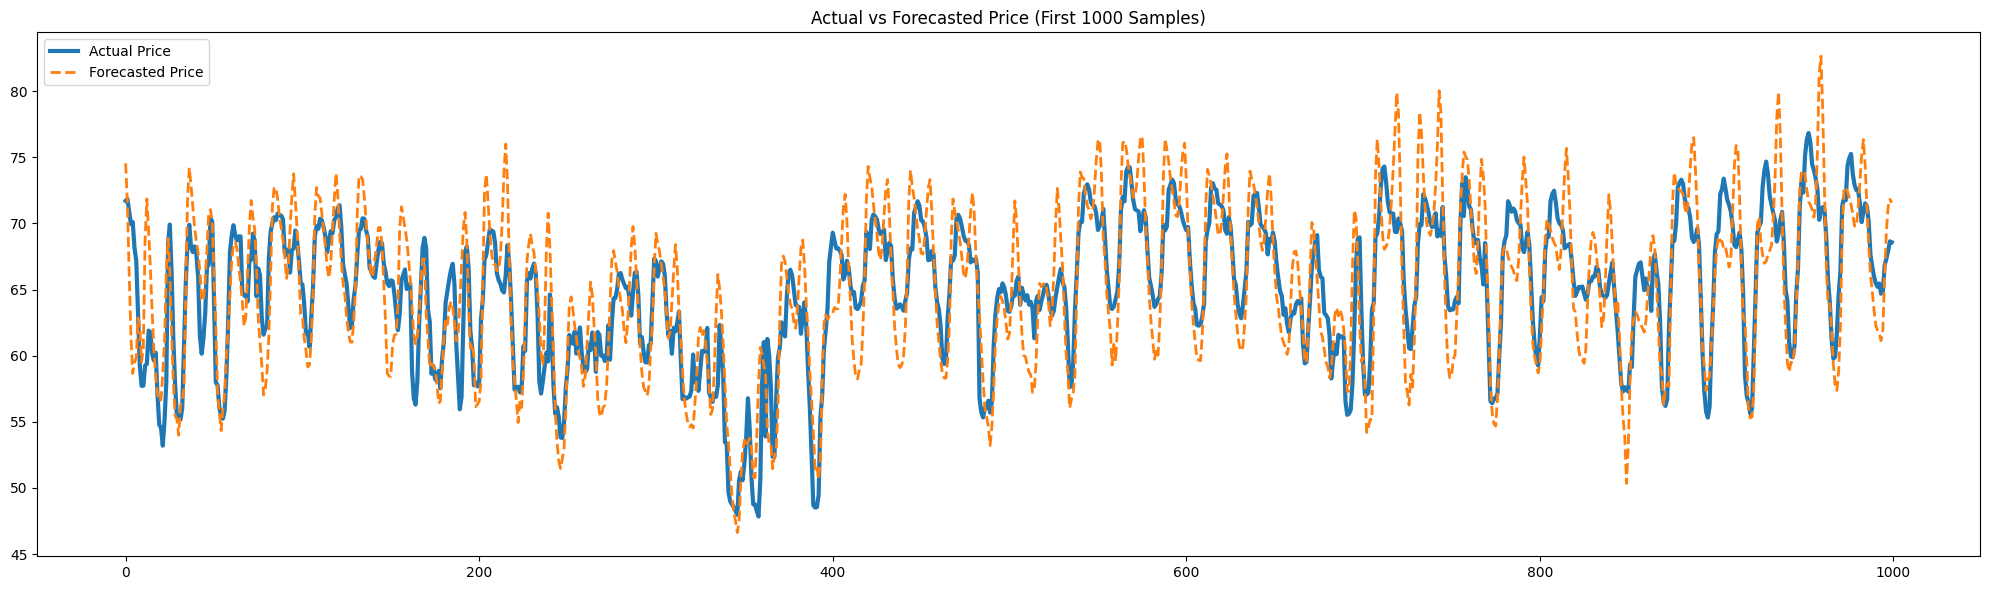

sm_load_mse: 642809.2477988701
sm_load_mae: 579.3270825929122
sm_price_mse: 11.263973020617057
sm_price_mae: 2.63973048082316


In [89]:
single_step_multi_output_model = load_model('single_step_multi_output_model.h5')

forecast = model_forecast(model=single_step_multi_output_model, test_series=valid_s, window_size=window_size, batch_size=batch_size)

load_prediction_scaled = forecast[:-1,0].copy()
price_prediction_scaled = forecast[:-1,1].copy()

load_actual_scaled = valid_s['total load actual scaled'][window_size:].to_list()
price_actual_scaled = valid_s['price actual scaled'][window_size:].to_list()



load_prediction_original = load_scaler.inverse_transform(forecast[:-1,0].reshape(-1,1))
price_prediction_original = price_scaler.inverse_transform(forecast[:-1,1].reshape(-1,1))

load_actual_original = valid.iloc[window_size:]['total load actual'].to_list()
price_actual_original = valid.iloc[window_size:]['price actual'].to_list()

sm_load_mse = mean_squared_error(load_actual_original, load_prediction_original)
sm_load_mae = mean_absolute_error(load_actual_original, load_prediction_original)

sm_price_mse = mean_squared_error(price_actual_original, price_prediction_original)
sm_price_mae = mean_absolute_error(price_actual_original, price_prediction_original)



fig, ax = plt.subplots(figsize=(20,6))
ax.plot(load_actual_original[:1000], c='Tomato', label='Actual Load', linestyle='-', linewidth=3)
ax.plot(load_prediction_original[:1000], c='LimeGreen', label='Forecasted Load', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Load (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize price actual vs prediction
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual_original[:1000], c='#1f77b4', label='Actual Price', linestyle='-', linewidth=3)
ax.plot(price_prediction_original[:1000], c='#ff7f0e', label='Forecasted Price', linestyle='--', linewidth=2)
ax.set_title('Actual vs Forecasted Price (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()


print(f'sm_load_mse: {sm_load_mse}')
print(f'sm_load_mae: {sm_load_mae}')

print(f'sm_price_mse: {sm_price_mse}')
print(f'sm_price_mae: {sm_price_mae}')
# single_step_multi_output_model.save('single_step_multi_output_model.h5')

#### 4-1-3, Ss Single Output (XGBoost)

Feature Engineering

In [30]:
# Function to add lagged features
def add_lagged_features(df, lags):
    # Initialize dictionary to store lagged features
    lagged_features = {}

    # Add lagged features for 'total load actual' and 'price actual'
    for lag in range(1, lags+1):
        lagged_features[f'total load actual lag_{lag}'] = df['total load actual'].shift(lag)
        lagged_features[f'price actual lag_{lag}'] = df['price actual'].shift(lag)
        lagged_features[f'total load actual rolling lag_{lag}'] = df['total load actual rolling'].shift(lag)
        lagged_features[f'price actual rolling lag_{lag}'] = df['price actual rolling'].shift(lag)


    # Use pd.concat to add all the lagged features at once
    df = pd.concat([df, pd.DataFrame(lagged_features, index=df.index)], axis=1)

    # Dropping NaN values resulting from shifting operation
    df.dropna(inplace=True)

    return df


# Add lagged features
train_lagged = add_lagged_features(train_xgb, lags=48)
valid_lagged = add_lagged_features(valid_xgb, lags=48)
test_lagged = add_lagged_features(test_xgb, lags=48)

train_x = train_lagged.drop(['total load actual', 'price actual','total load actual rolling', 'price actual rolling'], axis=1)
train_load = train_lagged['total load actual']
train_price = train_lagged['price actual']

valid_x = valid_lagged.drop(['total load actual', 'price actual','total load actual rolling', 'price actual rolling'], axis=1)
valid_load = valid_lagged['total load actual']
valid_price = valid_lagged['price actual']

test_x = test_lagged.drop(['total load actual', 'price actual','total load actual rolling', 'price actual rolling'], axis=1)
test_load = test_lagged['total load actual']
test_price = test_lagged['price actual']


Load Model

In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(2, 7, 1),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.2, 'reg_alpha': 0.2, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2}
Lowest RMSE for total load actual:  529.2745306959305


In [ ]:

# Define parameter grid
param_grid = {
    'reg_lambda': [0.1, 0.2, 0.3],
    'reg_alpha': [0.1, 0.2, 0.3],
    'objective': ['reg:squarederror'],
    'max_depth': [5, 6],
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [500],
    'min_child_weight': [1, 2],
    'gamma': [0.1, 0.2, 0.3],
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for total load actual:  {'reg_lambda': 0.2, 'reg_alpha': 0.3, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1}
Lowest RMSE for total load actual:  528.5536833103358


In [ ]:
dtrain_load = xgb.DMatrix(train_x, label=train_load)

# Define the parameters for the model
parameters = {'reg_lambda': 0.2,
              'reg_alpha': 0.3,
              'objective': 'reg:squarederror',
              'min_child_weight': 1,
              'max_depth': 6,
              'learning_rate': 0.05,
              'gamma': 0.1}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=8000,
    nfold=5,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

best_num_boost_round = cv_results['test-rmse-mean'].idxmin()

load_final_model = xgb.train(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=best_num_boost_round
)
#load_final_model.save_model('xgb_load_final_model.json')

[0]	train-rmse:4310.50260+4.07326	train-mae:3682.85014+3.81361	test-rmse:4311.69156+16.22101	test-mae:3683.78647+17.14385
[200]	train-rmse:340.53608+4.43488	train-mae:239.09903+2.83646	test-rmse:499.94077+26.51083	test-mae:317.84638+4.14989
[400]	train-rmse:249.11218+2.97086	train-mae:181.03453+1.83490	test-rmse:480.47371+28.48539	test-mae:298.73537+4.74643
[600]	train-rmse:192.44383+2.90559	train-mae:143.30291+1.76295	test-rmse:471.95018+28.92512	test-mae:290.21749+4.21115
[800]	train-rmse:153.63556+2.31197	train-mae:115.94412+1.60381	test-rmse:467.19780+29.67925	test-mae:285.37577+4.21224
[1000]	train-rmse:124.01735+2.09045	train-mae:94.26703+1.38749	test-rmse:464.23601+30.13054	test-mae:282.26692+4.38509
[1200]	train-rmse:101.64219+1.19519	train-mae:77.60371+0.77601	test-rmse:462.39825+30.47991	test-mae:280.23836+4.53417
[1400]	train-rmse:84.19884+0.97181	train-mae:64.36296+0.62792	test-rmse:461.23722+30.53925	test-mae:279.06907+4.56792
[1600]	train-rmse:70.05810+0.89244	train-mae:5

In [105]:
xgb_load_final_model = xgb.Booster()
xgb_load_final_model.load_model('xgb_load_final_model.json')

# Prediction
dval_load = xgb.DMatrix(valid_x, label=valid_load)
xgb_valid_load_prediction = xgb_load_final_model.predict(dval_load).reshape(-1, 1)


xgb_valid_load = valid_load.values.reshape(-1, 1)

xgb_load_mae = mean_absolute_error(xgb_valid_load_prediction, xgb_valid_load)
xgb_load_mse = mean_squared_error(xgb_valid_load_prediction, xgb_valid_load)
print(f"xgb load mae: {xgb_load_mae}")
print(f"xgb load mse: {xgb_load_mse}")

# load_final_model.save_model('xgb_load_final_model.json')

xgb load mae: 297.13971500411503
xgb load mse: 212450.77544503688


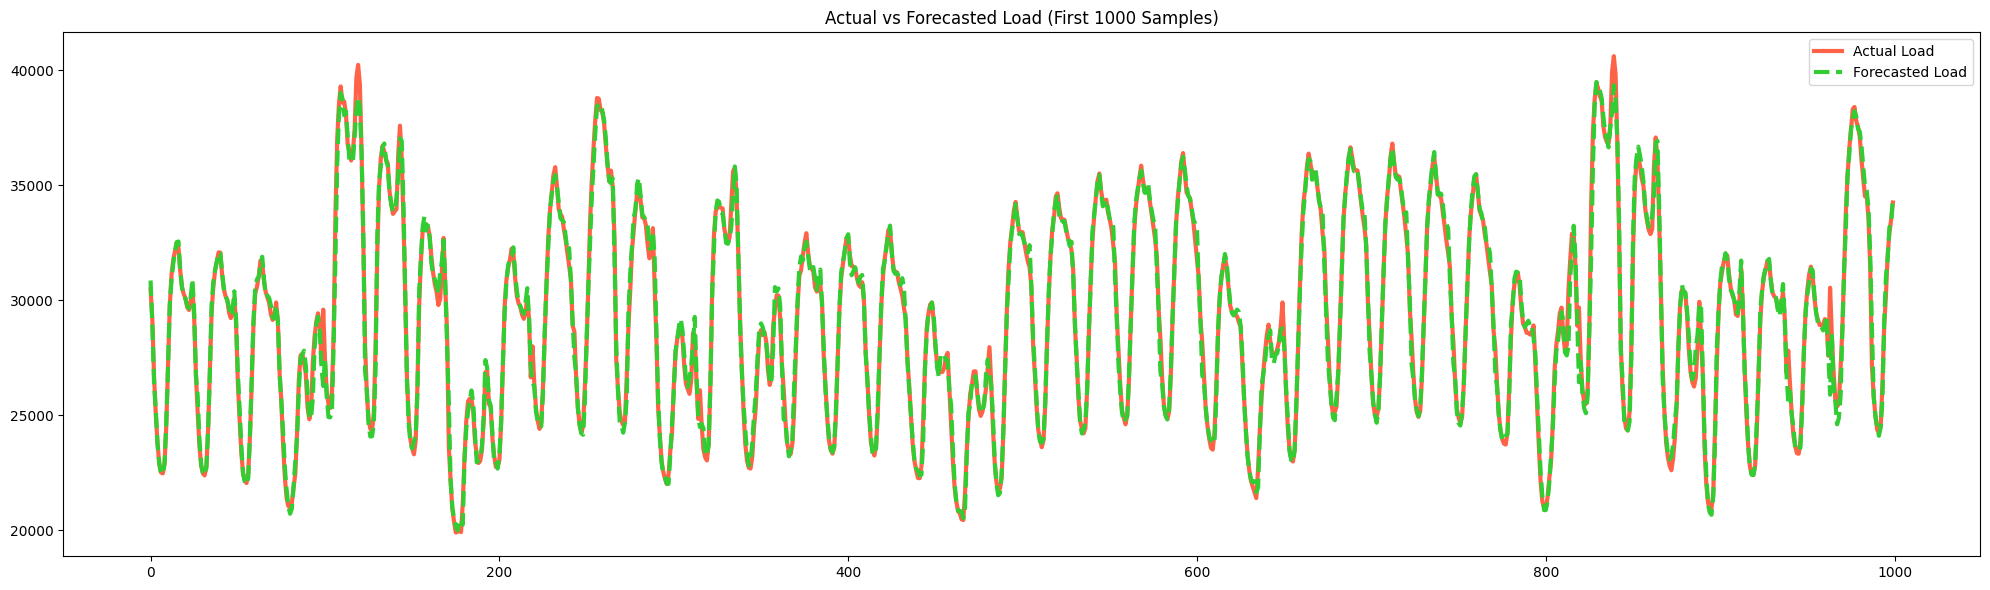

In [91]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(xgb_valid_load[:1000], c='Tomato', label='Actual Load', linestyle='-', linewidth=3)
ax.plot(xgb_valid_load_prediction[:1000], c='LimeGreen', label='Forecasted Load', linestyle='--', linewidth=3)
ax.set_title('Actual vs Forecasted Load (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

Price Model

In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(3, 6, 1),
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [800],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for price actual
random_search_price = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_price.fit(train_x, train_price)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_price.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_price.best_score_)))

In [ ]:
dtrain_price = xgb.DMatrix(train_x, label=train_price)

# Define the parameters for the model
parameters = {'reg_lambda': 0.2,
              'reg_alpha': 0.2,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 3,
              'learning_rate': 0.05,
              'gamma': 0.2}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=3000,
    nfold=3,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

best_num_boost_round = cv_results['test-rmse-mean'].idxmin()

In [ ]:
xgb_price_final_model = xgb.train(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=best_num_boost_round
)

In [ ]:
xgb_price_final_model.save_model('xgb_price_final_model.json')

In [106]:
xgb_price_final_model = xgb.Booster()
xgb_price_final_model.load_model('xgb_price_final_model.json')

# Prediction
dval_price = xgb.DMatrix(valid_x)
price_prediction = xgb_price_final_model.predict(dval_price).reshape(-1, 1)
price_actual = valid_price.values.reshape(-1, 1)

xgb_price_mae = mean_absolute_error(price_prediction, price_actual)
xgb_price_mse = mean_squared_error(price_prediction, price_actual)

print(f"Price Mean Absolute Error (MAE): {xgb_price_mae}")
print(f"Price Mean Squared Error (MSE): {xgb_price_mse}")


#xgb_price_final_model.save_model('xgb_price_final_model.json')

Price Mean Absolute Error (MAE): 1.2778504338105643
Price Mean Squared Error (MSE): 2.755321672543805


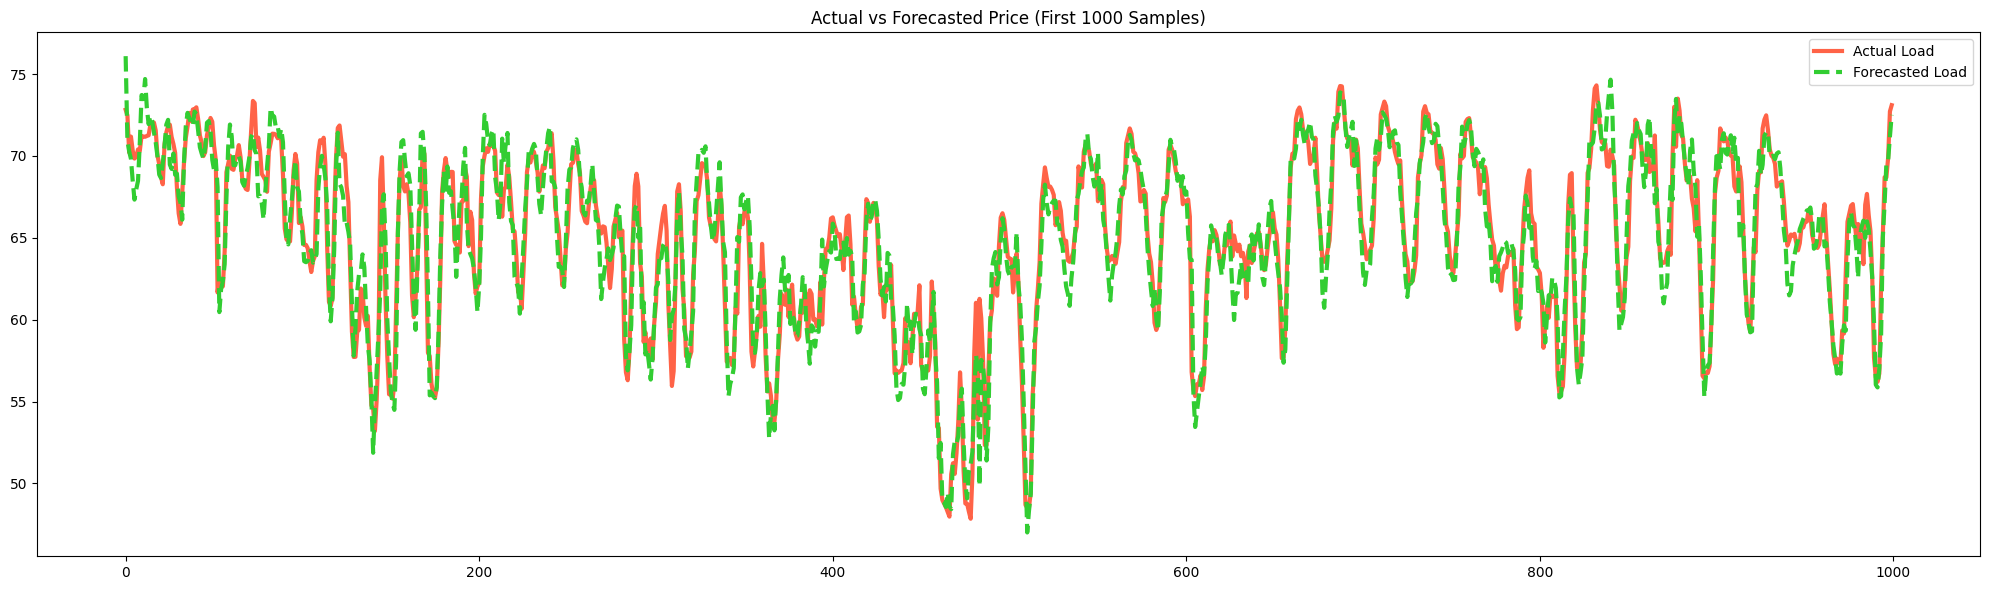

In [92]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual[:1000], c='Tomato', label='Actual Load', linestyle='-', linewidth=3)
ax.plot(price_prediction[:1000], c='LimeGreen', label='Forecasted Load', linestyle='--', linewidth=3)
ax.set_title('Actual vs Forecasted Price (First 1000 Samples)')
plt.legend()
plt.tight_layout()
plt.show()

Clearly, from the plots above, it is easy to see that XGBoost performs better than the previous two models on price prediction

In [93]:
# Evaluation
print(f'ss load mse: {ss_load_mse}')
print(f'sm load_mse: {sm_load_mse}')
print(f"xgb load mse: {xgb_load_mse}")


print(f'ss load mae: {ss_load_mae}')
print(f'sm load mae: {sm_load_mae}')
print(f"xgb load mae: {xgb_load_mae}")


print(f'ss price mse: {ss_price_mse}')
print(f'sm price mse: {sm_price_mse}')
print(f"xgb price mse: {xgb_price_mae}")


print(f'ss price mae: {ss_price_mae}')
print(f'sm pricemae: {sm_price_mae}')
print(f"xgb price mase: {xgb_price_mse}")

ss load mse: 561750.9491855024
sm load_mse: 642809.2477988701
xgb load mse: 212450.77544503688
ss load mae: 583.4251259773558
sm load mae: 579.3270825929122
xgb load mae: 297.13971500411503
ss price mse: 10.355359700748807
sm price mse: 11.263973020617057
xgb price mse: 1.2778504338105643
ss price mae: 2.600157564412666
sm pricemae: 2.63973048082316
xgb price mase: 2.755321672543805


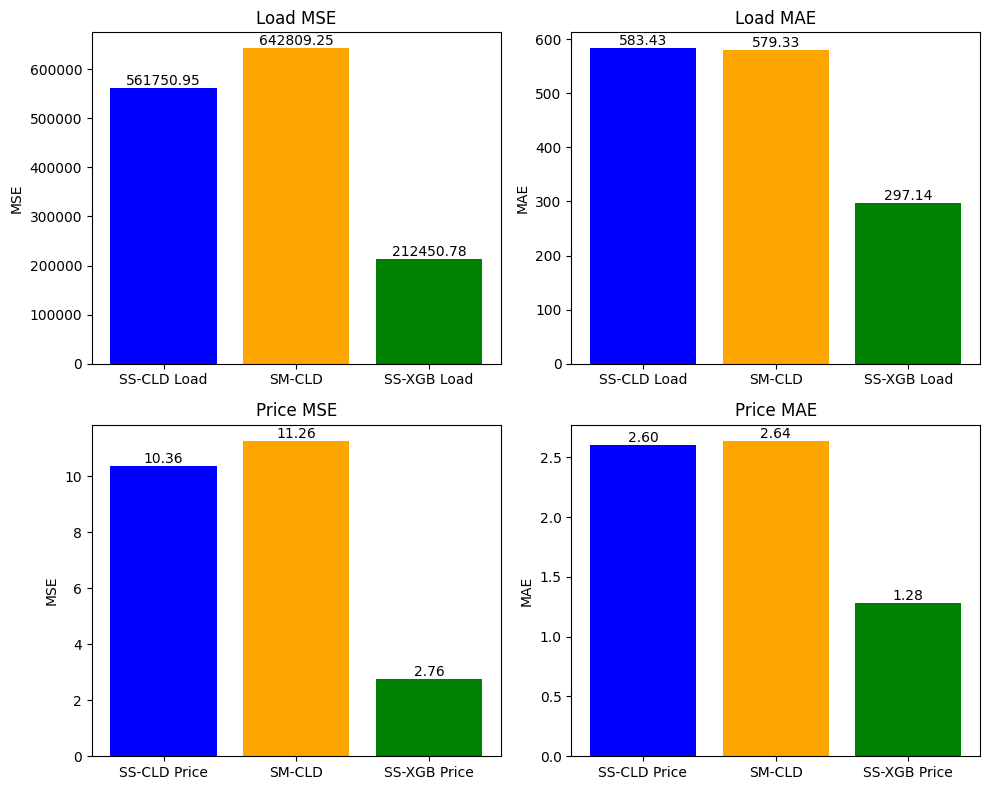

In [94]:
colors = ['blue', 'orange', 'green']

load_mse_values = [ss_load_mse, sm_load_mse, xgb_load_mse]
load_mae_values = [ss_load_mae, sm_load_mae, xgb_load_mae]

price_mse_values = [ss_price_mse, sm_price_mse, xgb_price_mse]
price_mae_values = [ss_price_mae, sm_price_mae, xgb_price_mae]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))


bars = axs[0,0].bar(['SS-CLD Load', 'SM-CLD', "SS-XGB Load"], load_mse_values, color=colors)
axs[0,0].set_title('Load MSE')
axs[0,0].set_ylabel('MSE')
axs[0,0].bar_label(bars, fmt='%.2f')


bars = axs[0,1].bar(['SS-CLD Load', 'SM-CLD', "SS-XGB Load"], load_mae_values, color=colors)
axs[0,1].set_title('Load MAE')
axs[0,1].set_ylabel('MAE')
axs[0,1].bar_label(bars, fmt='%.2f')


bars = axs[1,0].bar(['SS-CLD Price', 'SM-CLD', "SS-XGB Price"], price_mse_values, color=colors)
axs[1,0].set_title('Price MSE')
axs[1,0].set_ylabel('MSE')
axs[1,0].bar_label(bars, fmt='%.2f')


bars = axs[1,1].bar(['SS-CLD Price', 'SM-CLD', "SS-XGB Price"], price_mae_values, color=colors)
axs[1,1].set_title('Price MAE')
axs[1,1].set_ylabel('MAE')
axs[1,1].bar_label(bars, fmt='%.2f')

plt.tight_layout()
plt.show()

The results above indicate that XGBoost performs better, so we will use it for further autoregressive forecasting.

In [48]:
# Autoregressive Forecasting
def autoregressive_forecast(load_model, price_model, last_row, forecast_size=24, lag_size=48, rolling_size=8):
    load_pre = []
    price_pre = []

    current_input_bus = last_row.copy()
    current_time = pd.to_datetime(current_input_bus.index[-1])

    for _ in range(forecast_size):
        # Convert current_input_bus to DMatrix for XGBoost
        dmatrix_input = xgb.DMatrix(current_input_bus)

        # Predict load and price
        predicted_load = load_model.predict(dmatrix_input)[0]
        predicted_price = price_model.predict(dmatrix_input)[0]
        load_pre.append(predicted_load)
        price_pre.append(predicted_price)

        # Shift lag features (shift all by 1 step backwards)
        current_input_bus[[f'total load actual lag_{i}' for i in range(2, lag_size+1)]] = current_input_bus[
            [f'total load actual lag_{i-1}' for i in range(2, lag_size+1)]
        ]
        current_input_bus[[f'price actual lag_{i}' for i in range(2, lag_size+1)]] = current_input_bus[
            [f'price actual lag_{i-1}' for i in range(2, lag_size+1)]
        ]

        # Insert the new predicted values into lag_1
        current_input_bus['total load actual lag_1'] = predicted_load
        current_input_bus['price actual lag_1'] = predicted_price

        # Compute new rolling averages based on rolling_size
        # Use rolling() function to compute the rolling mean
        current_input_bus['total load actual rolling lag_1'] = current_input_bus[
            [f'total load actual lag_{i}' for i in range(1, rolling_size+1)]
        ].mean(axis=1)

        current_input_bus['price actual rolling lag_1'] = current_input_bus[
            [f'price actual lag_{i}' for i in range(1, rolling_size+1)]
        ].mean(axis=1)

        # Update time by adding 1 hour
        current_time += pd.Timedelta(hours=1)
        # Update hour and dayofweek
        current_input_bus['hour'] = current_time.hour
        current_input_bus['dayofweek'] = current_time.dayofweek

    return load_pre, price_pre

def generate_rolling_forecast(load_model, price_model, data, forecast_size=24, lag_size=48, rolling_size=8):
    all_load_predictions = []
    all_price_predictions = []

    # Iterate through each row to make predictions
    for idx in range(len(data)):
        last_row = data.iloc[idx:idx+1]
        # Call autoregressive_forecast to make predictions
        load_pre, price_pre = autoregressive_forecast(
            load_model,
            price_model,
            last_row=last_row,
            forecast_size=forecast_size,
            lag_size=lag_size,
            rolling_size=rolling_size
        )

        all_load_predictions.append(load_pre)
        all_price_predictions.append(price_pre)

    # Convert the prediction results into DataFrames
    load_predictions_df = pd.DataFrame(all_load_predictions, index=data.index, columns=[f'load_pred_{i}' for i in range(forecast_size)])
    price_predictions_df = pd.DataFrame(all_price_predictions, index=data.index, columns=[f'price_pred_{i}' for i in range(forecast_size)])

    return load_predictions_df, price_predictions_df

In [31]:
# Evaluation

# For simplicity, we selected a subset of the validation set consisting of 30 days (24*30 steps),
# starting from the 5th day (24*5 steps). This subset will be used to evaluate the XGBoost model
# along with two other Multi-step CLD models.
eval_sample_input = valid_x.iloc[24*5:24*5+24*30].copy()
eval_sample_load = valid_load[24*5:24*5+24*30+23].copy()
eval_sample_price = valid_price[24*5:24*5+24*30+23].copy()

In [32]:
# Perform forecasting
load_pred_df, price_pred_df = generate_rolling_forecast(
    load_model=xgb_load_final_model,
    price_model=xgb_price_final_model,
    data=eval_sample_input,
    forecast_size=24,
    lag_size=48,
    rolling_size=8
)

NameError: name 'generate_rolling_forecast' is not defined

In [33]:
# In fact, we don't need this cell, we can just use actual_load/price_original obtained from next section, seq2vec. To make seach section independently,
# we apply this funciton to generate actual values
def create_rolling_window(dataset, window_size=24):
    """
    Converts a 1D dataset into a 2D dataset with a rolling window.

    Parameters:
    dataset (pd.Series or np.array): The input 1D array or series.
    window_size (int): The size of the rolling window (number of steps).

    Returns:
    np.array: A 2D array where each row contains the next 'window_size' values.
    """
    rolling_window = np.lib.stride_tricks.sliding_window_view(dataset, window_size)

    return rolling_window

eval_load_rolled = create_rolling_window(eval_sample_load.to_numpy(), window_size=24)
eval_price_rolled = create_rolling_window(eval_sample_price.to_numpy(), window_size=24)

In [53]:
xgb_autoregressive_load_mae = mean_absolute_error(eval_load_rolled, load_pred_df)
xgb_autoregressive_load_mse = mean_squared_error(eval_load_rolled, load_pred_df)

xgb_autoregressive_price_mae = mean_absolute_error(eval_price_rolled, price_pred_df)
xgb_autoregressive_price_mse = mean_squared_error(eval_price_rolled, price_pred_df)

print(f"xgb autoregressive mse: {xgb_autoregressive_load_mse}")
print(f"xgb autoregressive mae: {xgb_autoregressive_load_mae}")

print(f"xgb autoregressive price mse: {xgb_autoregressive_price_mse}")
print(f"xgb autoregressive price mae: {xgb_autoregressive_price_mae}")

xgb autoregressive mse: 7673623.587052769
xgb autoregressive mae: 1831.1576111970123
xgb autoregressive price mse: 23.459665325076298
xgb autoregressive price mae: 3.539344004410283


### 4.2 Multi-Step



#### 4-2-1, Single Shot Single/Multi-Output (seq2vec, CNN-LSTM-DNN)

In [26]:
# Seq2vec
def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the input variables
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True) # This is different from single step model: "+ forecast_size"

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1))) # forecast_size=1 refers to single step

    if shuffle_buffer_size is not None:
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #tf.keras.layers.Conv1D(filters=64, kernel_size=6, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.Conv1D(filters=64, kernel_size=12, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(24 * len(output_cols)),
        tf.keras.layers.Reshape([24, len(output_cols)])
    ])
    return model

def create_model():  # Adam works well with a smaller learning rate
    # Set the optimizer to Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # Compile the model
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

input_cols = train_s.columns.to_list()
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

# Parameters
window_size = 24 * 7
batch_size = 32
shuffle_buffer_size = 4000 # this value depends on the size of the data, around the len(data) for small data and small len(data) for big data
forecast_size = 24


train_set = windowed_dataset(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)

valid_set = windowed_dataset(series = valid_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

In [ ]:
s2v_model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

history = s2v_model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])

# s2v_model.save('s2v_model.h5')



In [27]:
s2v_model = load_model('s2v_model.h5')

# Forecast
valid_predictions =s2v_model.predict(valid_set)

# Actual values
valid_actual_labels = np.concatenate([y for x, y in valid_set.as_numpy_iterator()])

# Reshape it so that you can inverse scale each feature separately
predicted_load = valid_predictions[:, :, 0].reshape(-1, 1)
predicted_price = valid_predictions[:, :, 1].reshape(-1, 1)

# Apply inverse transform using the corresponding scalers
predicted_load_original = load_scaler.inverse_transform(predicted_load).reshape(valid_predictions.shape[0], valid_predictions.shape[1])
actual_load_scaled = valid_actual_labels[:, :, 0].reshape(-1, 1)
actual_load_original = load_scaler.inverse_transform(actual_load_scaled).reshape(valid_predictions.shape[0], valid_predictions.shape[1])

predicted_price_original = price_scaler.inverse_transform(predicted_price).reshape(valid_predictions.shape[0], valid_predictions.shape[1])
actual_price_scaled = valid_actual_labels[:, :, 1].reshape(-1, 1)
actual_price_original = price_scaler.inverse_transform(actual_price_scaled).reshape(valid_predictions.shape[0], valid_predictions.shape[1])

# Evaluatation
mae_load = mean_absolute_error(actual_load_original, predicted_load_original)
mse_load = mean_squared_error(actual_load_original, predicted_load_original)
mae_price = mean_absolute_error(actual_price_original, predicted_price_original)
mse_price = mean_squared_error(actual_price_original, predicted_price_original)

print(f"Load MAE: {mae_load}")
print(f"Load MSE: {mse_load}")

print(f"Price MAE: {mae_price}")
print(f"Price MSE: {mse_price}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Load MAE: 1575.9256591796875
Load MSE: 5004379.0
Price MAE: 4.180210590362549
Price MSE: 27.831878662109375


In [34]:
# Evaluation
# We select a subset of the validation set for evaluation, consistant with the XGBoost case
s2v_eval_load_prediction = predicted_load_original[:24*30]
s2v_eval_price_prediction = predicted_price_original[:24*30]


s2v_load_mae = mean_absolute_error(eval_load_rolled, s2v_eval_load_prediction)
s2v_load_mse = mean_squared_error(eval_load_rolled, s2v_eval_load_prediction)

s2v_price_mae = mean_absolute_error(eval_price_rolled, s2v_eval_price_prediction)
s2v_price_mse = mean_squared_error(eval_price_rolled, s2v_eval_price_prediction)



print(f"Load MAE: {s2v_load_mae}")
print(f"Load MSE: {s2v_load_mse}")

print(f"Price MAE: {s2v_price_mae}")
print(f"Price MSE: {s2v_price_mse}")

Load MAE: 1304.3709445529514
Load MSE: 3445171.9447054616
Price MAE: 3.960015084054728
Price MSE: 24.439154629394352


#### 4-2-1, Seq2seq Single/Multi-Output (CNN-LSTM-DNN)

In [35]:
# Seq2seq

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True) # This is different from single step model: "+ forecast_size"

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    dataset = dataset.map(lambda window: (
        # Encoder input: the past time steps for the encoder (window_size)
        tf.gather(window[:window_size], input_cols, axis=-1),

        # Decoder targets: gather the next forecast_size steps for each step in the window
        tf.stack([tf.gather(window[i+1:i+1+forecast_size], output_cols, axis=-1)
                  for i in range(window_size)])
    ))


    if shuffle_buffer_size is not None:
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def create_uncompiled_model():
    """Creates an uncompiled sequential model with Conv1D, LSTM, and Dense layers.

    Returns:
        model (Sequential): Uncompiled Keras Sequential model.
    """

    model = tf.keras.models.Sequential([
        # Conv1D layer with causal padding
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                               input_shape=[None, len(input_cols)]),
        #tf.keras.layers.Conv1D(filters=64, kernel_size=6, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.Conv1D(filters=64, kernel_size=12, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(forecast_size * len(output_cols))),
        tf.keras.layers.Reshape((window_size, forecast_size, len(output_cols)))
    ])

    return model

def create_model():  # Adam works well with a smaller learning rate
    # Set the optimizer to Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # Compile the model
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

input_cols = train_s.columns.to_list()
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

# Parameters
window_size = 24*7
batch_size = 32
shuffle_buffer_size = 4000 # this value depends on the size of the data, around the len(data) for small data and small len(data) for big data
forecast_size = 24


train_set = windowed_dataset(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)
valid_set = windowed_dataset(valid_s,
                             window_size,
                             batch_size,
                             None,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)


In [ ]:
s2s_model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)

history = s2s_model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])
#s2s_model.save('s2s_model.h5')

In [36]:
s2s_model = tf.keras.models.load_model('s2s_model.h5')

val_predictions = s2s_model.predict(valid_set)

77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [37]:
# Load
load_prediction_scaled = val_predictions[:,-1,:,0]
load_prediction_original = load_scaler.inverse_transform(load_prediction_scaled)

load = np.concatenate([y for x, y in valid_set.as_numpy_iterator()])
load_actual_scaled = load[:,-1,:,0]
load_actual_original = load_scaler.inverse_transform(load_actual_scaled)

# Price
price_prediction_scaled = val_predictions[:,-1,:,1]
price_prediction_original = price_scaler.inverse_transform(price_prediction_scaled)

price = np.concatenate([y for x, y in valid_set.as_numpy_iterator()])
price_actual_scaled = price[:,-1,:,1]
price_actual_original = price_scaler.inverse_transform(price_actual_scaled)

seq2seq_load_mse = mean_squared_error(load_actual_original, load_prediction_original)
seq2seq_load_mae = mean_absolute_error(load_actual_original, load_prediction_original)

seq2seq_price_mse = mean_squared_error(load_actual_original, load_prediction_original)
seq2seq_price_mae = mean_absolute_error(load_actual_original, load_prediction_original)

print(f"Load MAE: {seq2seq_load_mae}")
print(f"Load MSE: {seq2seq_load_mse}")

print(f"Price MAE: {seq2seq_price_mae}")
print(f"Price MSE: {seq2seq_price_mse}")

Load MAE: 1414.0579833984375
Load MSE: 4384524.0
Price MAE: 1414.0579833984375
Price MSE: 4384524.0


In [38]:
# Evaluation
# We select a subset of the validation set for evaluation, consistant with the XGBoost case
s2s_eval_load_prediction = load_prediction_original[:24*30]
s2s_eval_price_prediction = price_prediction_original[:24*30]

s2s_load_mse = mean_squared_error(eval_load_rolled, s2s_eval_load_prediction)
s2s_load_mae = mean_absolute_error(eval_load_rolled, s2s_eval_load_prediction)

s2s_price_mse = mean_squared_error(eval_price_rolled, s2s_eval_price_prediction)
s2s_price_mae = mean_absolute_error(eval_price_rolled, s2s_eval_price_prediction)

print(f"Load MAE: {s2s_load_mae}")
print(f"Load MSE: {s2s_load_mse}")

print(f"Price MAE: {s2s_price_mae}")
print(f"Price MSE: {s2s_price_mse}")

Load MAE: 1212.6503514042606
Load MSE: 3167761.1268374785
Price MAE: 3.5451474139690355
Price MSE: 20.263829498357435


## 4. Evaluation

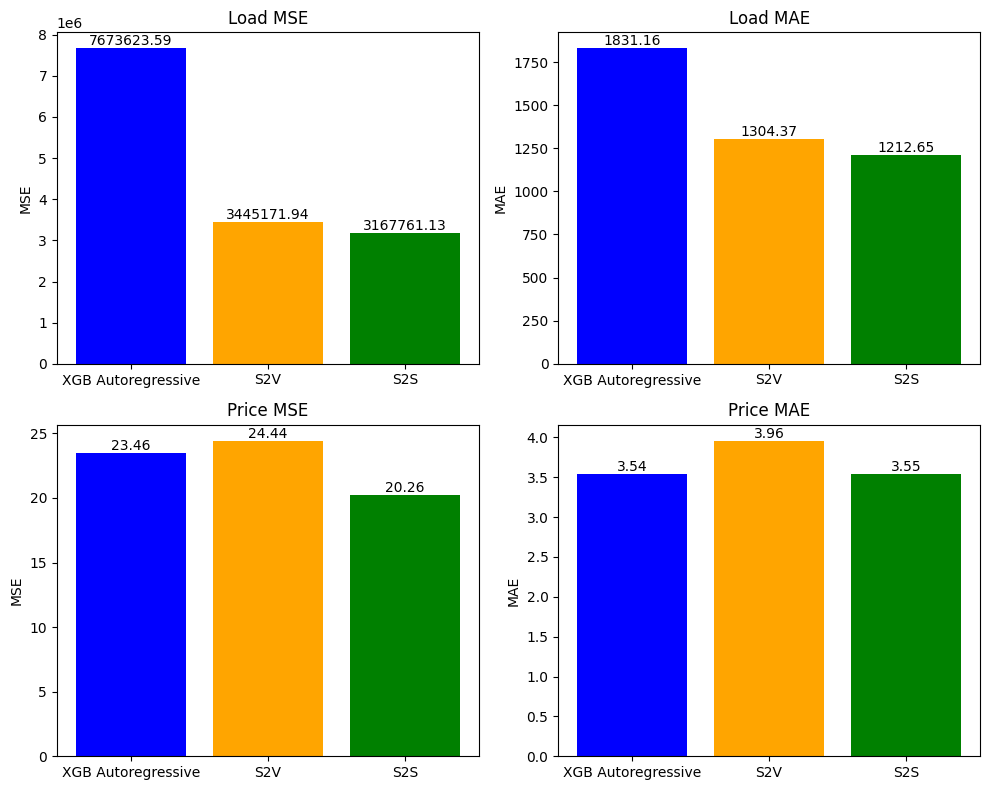

In [41]:
# Visualizing the performance of three models: XGBoost+Autoregressive, seq2vec CLD, seq2seq CLD

# Colors for the bars
colors = ['blue', 'orange', 'green']

# Load MSE and MAE values for each method
load_mse_values = [xgb_autoregressive_load_mse, s2v_load_mse, s2s_load_mse]
load_mae_values = [xgb_autoregressive_load_mae, s2v_load_mae, s2s_load_mae]

# Price MSE and MAE values for each method
price_mse_values = [xgb_autoregressive_price_mse, s2v_price_mse, s2s_price_mse]
price_mae_values = [xgb_autoregressive_price_mae, s2v_price_mae, s2s_price_mae]

# Create subplots for the comparisons
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Load MSE bar chart
bars = axs[0,0].bar(['XGB Autoregressive', 'S2V', 'S2S'], load_mse_values, color=colors)
axs[0,0].set_title('Load MSE')
axs[0,0].set_ylabel('MSE')
axs[0,0].bar_label(bars, fmt='%.2f')

# Load MAE bar chart
bars = axs[0,1].bar(['XGB Autoregressive', 'S2V', 'S2S'], load_mae_values, color=colors)
axs[0,1].set_title('Load MAE')
axs[0,1].set_ylabel('MAE')
axs[0,1].bar_label(bars, fmt='%.2f')

# Price MSE bar chart
bars = axs[1,0].bar(['XGB Autoregressive', 'S2V', 'S2S'], price_mse_values, color=colors)
axs[1,0].set_title('Price MSE')
axs[1,0].set_ylabel('MSE')
axs[1,0].bar_label(bars, fmt='%.2f')

# Price MAE bar chart
bars = axs[1,1].bar(['XGB Autoregressive', 'S2V', 'S2S'], price_mae_values, color=colors)
axs[1,1].set_title('Price MAE')
axs[1,1].set_ylabel('MAE')
axs[1,1].bar_label(bars, fmt='%.2f')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



NameError: name 'load_pred_df' is not defined

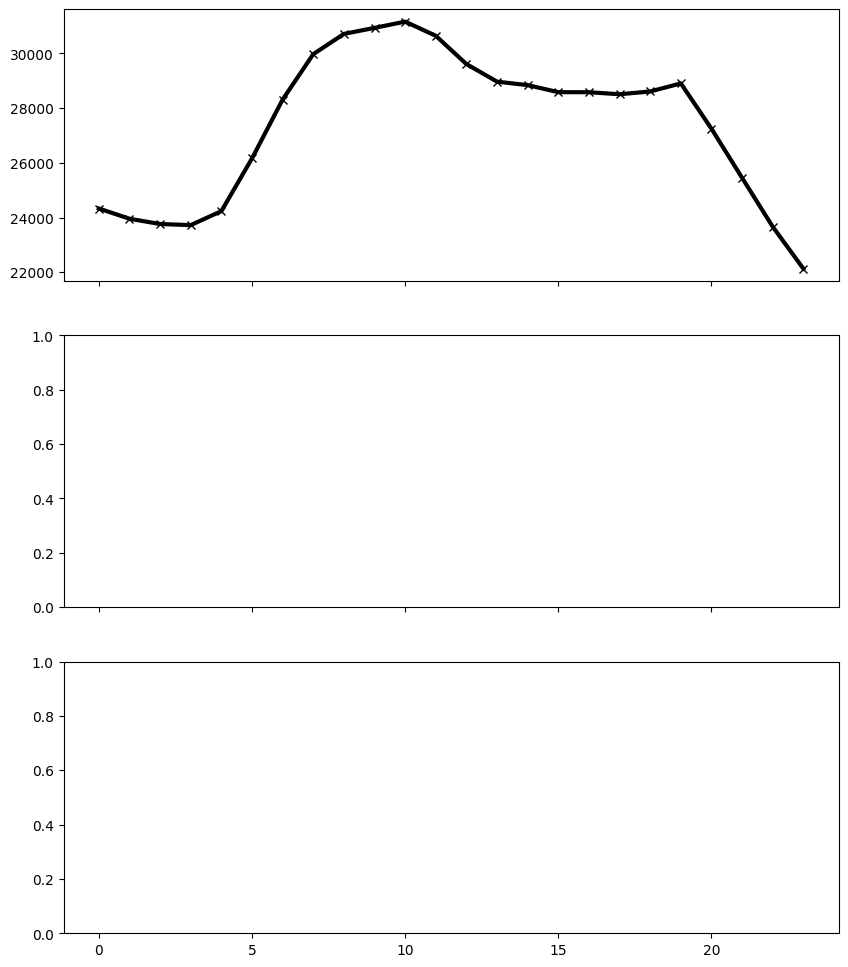

In [42]:
# Visualization
random.seed(42)

num_samples = len(eval_load_rolled)

# Randomly select 3 sample indices
random_numbers = 3
selected_indices = random.sample(range(num_samples), random_numbers)

# Create 3 subplots, all sharing the same X-axis
fig, axs = plt.subplots(random_numbers, 1, figsize=(10, 12), sharex=True)  # Increased figure size for better display

for i, n in enumerate(selected_indices):
    # Plot actual values and predicted values
    axs[i].plot(eval_load_rolled[n], label='Actual Load', linestyle='-', marker='x', c='black', linewidth=3)
    axs[i].plot(load_pred_df.values[n], label='XGB Predicted', linestyle='--', marker='o', c='blue', linewidth=2)
    axs[i].plot(s2v_eval_load_prediction[n], label='S2V Predicted', linestyle='--', marker='s', c='red', linewidth=2)
    axs[i].plot(s2s_eval_load_prediction[n], label='S2S Predicted', linestyle='--', marker='d', c='orange',linewidth=2)

    # Set a simple title for each subplot
    axs[i].set_title(f'Sample {n}')

    # Set consistent Y-axis limits for easier comparison
    #axs[i].set_ylim([min(eval_load_rolled[n]) - 2000, max(eval_load_rolled[n]) + 2000])

    # Set Y-axis label
    axs[i].set_ylabel('Load Value')

    axs[i].legend(loc='upper right')

# Add a global title for the entire figure
fig.suptitle('Comparison of Actual and Predicted Load for Randomly Selected Samples', fontsize=16)

# Set X-axis label for time steps
plt.xlabel('Time Steps')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Auto-adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the global title

# Display the plot
plt.show()


## 5. Deployment and Prediction